In [146]:
from qiskit import *
from qiskit_aer import *
import numpy as np
import csv

# Function to create a random string of bits
def random_bit_string(length):
    return ''.join(np.random.choice(['0', '1'], size=length))

# Function to encode the qubits by Alice
def alice_encode(qc, bits, bases):
    for i in range(len(bits)):
        if bases[i] == 0:  # Prepare qubit in Z-basis
            if bits[i] == '1':
                qc.x(i)
        elif bases[i] == 1:  # Prepare qubit in X-basis
            if bits[i] == '0':
                qc.h(i)
            else:
                qc.x(i)
                qc.h(i)

# Function to measure qubits by Bob
def bob_measure(qc, bases):
    for i in range(len(bases)):
        if bases[i] == 0:  # Measure qubit in Z-basis
            qc.measure(i, i)
        elif bases[i] == 1:  # Measure qubit in X-basis
            qc.h(i)
            qc.measure(i, i)
            qc.h(i)

# Function to simulate Eve's attack
def eve_attack(qc):
    for i in range(n):
        qc.measure(i, i)

# Function to compare bases between Alice and Bob
def compare_bases(bases_a, bases_b):
    return [bases_a[i] == bases_b[i] for i in range(len(bases_a))]

# Function to extract the key bits agreed upon by Alice and Bob
def extract_key(bits, bases, agreed_bases):
    return ''.join([bits[i] for i in range(len(bits)) if agreed_bases[i]])

# Function to write Alice, Bob, and Eve's messages to a CSV file
def write_to_csv(alice_message, bob_message, eve_message):
    with open('bb84_messages.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Alice Message', 'Bob Message', 'Eve Message'])
        for a, b, e in zip(alice_message, bob_message, eve_message):
            writer.writerow([a, b, e])


# Parameters
n = 20  # Number of qubits
alice_bases = [np.random.randint(2) for _ in range(n)]  # Random bases for Alice
bob_bases = [np.random.randint(2) for _ in range(n)]  # Random bases for Bob

# Random bits for Alice
alice_bits = random_bit_string(n)
alice_message = [chr(int(alice_bits[i:i+8], 2)) for i in range(0, len(alice_bits), 8)]

# Quantum circuit setup
qc = QuantumCircuit(n, n)

# Alice encodes her bits
alice_encode(qc, alice_bits, alice_bases)

# Eve intercepts and measures the qubits
eve_attack(qc)

# Bob measures the qubits
bob_measure(qc, bob_bases)

# Simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
job = simulator.run(qc, shots=1, memory=True)  # Specify memory=True to get individual measurement outcomes
result = job.result()
counts = result.get_counts()

# Extract Bob's bits from measurement outcomes
bob_bits_measured = list(counts.keys())[0]  # Bob's bits as a binary string

# Convert Bob's bits to bytes
bob_message = [bob_bits_measured[i:i+8] for i in range(0, len(bob_bits_measured), 8)]

# Convert Alice's bits to bytes
alice_bits_binary = ''.join([alice_bits[i] for i in range(len(alice_bits)) if alice_bases[i] == 0])

# Compare bases and extract the final key
agreed_bases = compare_bases(alice_bases, bob_bases)
final_key = extract_key(alice_bits_binary, alice_bases, agreed_bases)

# Write Alice, Bob, and Eve's messages to a CSV file
write_to_csv(alice_message, bob_message, alice_message)

# Print the results
print("Alice's message:", ''.join(alice_message))
print("Bob's message:", ''.join([chr(int(byte, 2)) for byte in bob_message]))
print("Final Key:", final_key)


Alice's message: ´À	
Bob's message: °R
Final Key: 010000


In [150]:
for i in range(1,10000):
    n = 20  # Number of qubits
    alice_bases = [np.random.randint(2) for _ in range(n)]  # Random bases for Alice
    bob_bases = [np.random.randint(2) for _ in range(n)]  # Random bases for Bob

# Random bits for Alice
    alice_bits = random_bit_string(n)
    alice_message = [chr(int(alice_bits[i:i+8], 2)) for i in range(0, len(alice_bits), 8)]

# Quantum circuit setup
    qc = QuantumCircuit(n, n)

# Alice encodes her bits
    alice_encode(qc, alice_bits, alice_bases)

# Eve intercepts and measures the qubits
    eve_attack(qc)

# Bob measures the qubits
    bob_measure(qc, bob_bases)

# Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    job = simulator.run(qc, shots=1, memory=True)  # Specify memory=True to get individual measurement outcomes
    result = job.result()
    counts = result.get_counts()

# Extract Bob's bits from measurement outcomes
    bob_bits_measured = list(counts.keys())[0]  # Bob's bits as a binary string

# Convert Bob's bits to bytes
    bob_message = [bob_bits_measured[i:i+8] for i in range(0, len(bob_bits_measured), 8)]

# Convert Alice's bits to bytes
    alice_bits_binary = ''.join([alice_bits[i] for i in range(len(alice_bits)) if alice_bases[i] == 0])

# Compare bases and extract the final key
    agreed_bases = compare_bases(alice_bases, bob_bases)
    final_key = extract_key(alice_bits_binary, alice_bases, agreed_bases)

# Write Alice, Bob, and Eve's messages to a CSV file
    write_to_csv(alice_message, bob_message, alice_message)

# Print the results
    print("Alice's message:", ''.join(alice_message))
    print("Bob's message:", ''.join([chr(int(byte, 2)) for byte in bob_message]))
    print("Final Key:", final_key)

Alice's message: ¬
Bob's message: %
Final Key: 100
Alice's message: ûj
Bob's message: úñ
Final Key: 11110
Alice's message: "Y 
Bob's message: Ì
Final Key: 01001000
Alice's message: j
Bob's message: Íå
Final Key: 10100010
Alice's message: § 
¼b's message: 
Final Key: 110
Alice's message: ¬¡ 
Bob's message:  Û
Final Key: 11101110
Alice's message: tá

Bob's message: [A 
Final Key: 0101
Alice's message: Þ
Bob's message: ß
Final Key: 00
Alice's message: Vá
Bob's message: ]

Final Key: 0111
Alice's message: M¾
Bob's message: ³Ø
Final Key: 011111
Alice's message: cÁ 
Bob's message: 
Final Key: 10100
Alice's message: !²
Bob's message: á	
Final Key: 001000001
Alice's message: tì
Bob's message: Tb
Final Key: 1010
Alice's message: =R
Bob's message: ûK
Final Key: 01011
Alice's message: *
Bob's message: W
Final Key: 000
Alice's message: eÆ

Bob's message: Ws
Final Key: 110101
Alice's message: ÒÁ
Bob's message: 'd
Final Key: 11011
Alice's message: ?

Bob's message: ïE
Fin

In [25]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import Aer

# Simulate a quantum hash function
def quantum_hash(input_string):
    binary_input = ''.join(format(ord(char), '08b') for char in input_string)
    length = len(binary_input)
    
    qc = QuantumCircuit(length, length)
    
    # Apply X gates where the binary input is 1
    for i in range(length):
        if binary_input[i] == '1':
            qc.x(i)
    
    # Apply Hadamard gates and CX gates for hashing
    qc.h(range(length))
    for i in range(0, length, 2):
        qc.cx(i, (i + 1) % length)
        qc.h(i)
    
    # Measure the qubits
    qc.measure(range(length), range(length))
    
    # Simulate the quantum circuit
    simulator = Aer.get_backend('qasm_simulator')
    result = simulator.run(qc,  shots=1024).result()
    counts = result.get_counts()
    
    # Get the most frequent result to ensure stability in the hash output
    hash_binary = max(counts, key=counts.get)
    return hash_binary

# BB84: Alice prepares and sends qubits
def bb84_protocol(n_bits=5, eve_involved=False):
    # Alice's random bits (message) and bases (0 = rectilinear, 1 = diagonal)
    alice_bits = np.random.randint(2, size=n_bits)
    alice_bases = np.random.randint(2, size=n_bits)
    
    # Bob's random bases
    bob_bases = np.random.randint(2, size=n_bits)
    
    # Eve's random bases (if Eve is eavesdropping)
    eve_bases = np.random.randint(2, size=n_bits) if eve_involved else None
    
    # Alice's qubits sent to Bob
    sent_qubits = []
    
    for i in range(n_bits):
        qc = QuantumCircuit(1, 1)
        if alice_bases[i] == 1:
            qc.h(0)  # Diagonal basis
        
        if alice_bits[i] == 1:
            qc.x(0)  # Prepare bit 1
        
        # If Eve is eavesdropping, she measures the qubit
        if eve_involved:
            if eve_bases[i] == 1:
                qc.h(0)  # Eve measures in the diagonal basis
            qc.measure(0, 0)
            result = Aer.get_backend('qasm_simulator').run(qc,shots=1).result()
            counts = result.get_counts()
            eve_result = int(max(counts, key=counts.get))
            # Eve may collapse the qubit, so reset for Bob
            qc = QuantumCircuit(1, 1)
            if eve_result == 1:
                qc.x(0)
        
        sent_qubits.append(qc)

    # Bob measures the qubits
    bob_results = []
    for i in range(n_bits):
        qc = sent_qubits[i]
        if bob_bases[i] == 1:
            qc.h(0)  # Bob measures in the diagonal basis
        qc.measure(0, 0)
        
        result = Aer.get_backend('qasm_simulator').run(qc, shots=1).result()
        counts = result.get_counts()
        bob_results.append(int(max(counts, key=counts.get)))
    
    # Compare Alice's and Bob's bases
    matching_indices = np.where(alice_bases == bob_bases)[0]
    alice_key = alice_bits[matching_indices]
    bob_key = np.array(bob_results)[matching_indices]
    
    print(f"Alice's key: {alice_key}")
    print(f"Bob's key: {bob_key}")
    
    # Detect if there are mismatches in the keys (due to eavesdropping)
    if np.array_equal(alice_key, bob_key):
        print("No eavesdropping detected.")
    else:
        print("Warning: Eavesdropping detected!")
    
    return alice_key, bob_key

# Simulate Alice sending a message with BB84
def alice_to_bob_bb84(eve_involved=False):
    # Step 1: Run BB84 to establish a shared key
    alice_key, bob_key = bb84_protocol(n_bits=5, eve_involved=eve_involved)
    
    # Step 2: Alice sends a message (binary string)
    message = "01101"  # Example message in binary form
    print(f"Alice's original message: {message}")
    
    # Step 3: Alice encrypts the message using the shared key (XOR encryption)
    def xor_encrypt(message, key):
        encrypted = ''.join(str(int(m) ^ int(k)) for m, k in zip(message, key[:len(message)]))
        return encrypted
    
    encrypted_message = xor_encrypt(message, alice_key)
    print(f"Encrypted message: {encrypted_message}")
    
    # Step 4: Alice generates a quantum hash of the original message
    hash_value = quantum_hash(message)
    print(f"Quantum hash of the original message: {hash_value}")
    
    # Step 5: Bob decrypts the message using his key
    decrypted_message = xor_encrypt(encrypted_message, bob_key)
    print(f"Bob's decrypted message: {decrypted_message}")
    
    # If the message decrypted correctly, no eavesdropping; otherwise, Eve was present
    if message == decrypted_message:
        print("Message integrity verified: No tampering.")
    else:
        print("Warning: Message tampered due to eavesdropping!")

# Simulate BB84 without Eve
print("BB84 Simulation without Eve:")
alice_to_bob_bb84(eve_involved=False)

print("\nBB84 Simulation with Eve eavesdropping:")
alice_to_bob_bb84(eve_involved=True)


BB84 Simulation without Eve:
Alice's key: [1]
Bob's key: [1]
No eavesdropping detected.
Alice's original message: 01101
Encrypted message: 1
Quantum hash of the original message: 1100101000101000011010100110000000000010
Bob's decrypted message: 0

BB84 Simulation with Eve eavesdropping:
Alice's key: [1 0]
Bob's key: [0 1]
Alice's original message: 01101
Encrypted message: 11
Quantum hash of the original message: 0100000010100000111010101110101000100000
Bob's decrypted message: 10


In [46]:
import numpy as np

# Function to convert string to binary
def string_to_binary(message):
    return ''.join(format(ord(char), '08b') for char in message)

# Function to convert binary to string
def binary_to_string(binary):
    chars = [chr(int(binary[i:i + 8], 2)) for i in range(0, len(binary), 8)]
    return ''.join(chars)

# Function to perform XOR encryption
def xor_encrypt(message, key):
    return ''.join(str(int(m) ^ int(k)) for m, k in zip(message, key))

# Function for key distribution using BB84
def key_distribution(num_bits):
    alice_key = np.random.randint(0, 2, num_bits)
    bob_key = np.random.randint(0, 2, num_bits)
    
    # Check for eavesdropping
    if np.random.rand() < 0.5:  # Simulate a 50% chance of eavesdropping
        print("Warning: Eavesdropping detected!")
        alice_key = (alice_key + np.random.randint(0, 2, num_bits)) % 2  # Modify Alice's key
    else:
        print("No eavesdropping detected.")

    return alice_key, bob_key

# Function to send a message from Alice to Bob
def alice_to_bob(user_message):
    binary_message = string_to_binary(user_message)  # Convert message to binary
    num_bits = len(binary_message)  # Total bits needed for the message
    print(f"Alice's original message: {user_message}")
    
    # Step 1: Key Distribution
    alice_key, bob_key = key_distribution(num_bits)
    print(f"Alice's key: {alice_key}")
    print(f"Bob's key: {bob_key}")
    
    # Step 2: Encrypt the message
    encrypted_message = xor_encrypt(binary_message, alice_key)
    print(f"Encrypted message: {encrypted_message}")

    # Step 3: Bob decrypts the message
    decrypted_binary_message = xor_encrypt(encrypted_message, bob_key)
    decrypted_message = binary_to_string(decrypted_binary_message)  # Convert binary back to string
    print(f"Bob's decrypted message: {decrypted_message}")

# Main function
def main():
    user_message = input("Enter a message for Alice to send to Bob: ")
    
    # Simulate BB84
    alice_to_bob(user_message)

# Run the main function
main()


Alice's original message: rup
Alice's key: [0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 1]
Bob's key: [1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0]
Encrypted message: 011110001110011001111111
Bob's decrypted message: ÃVó


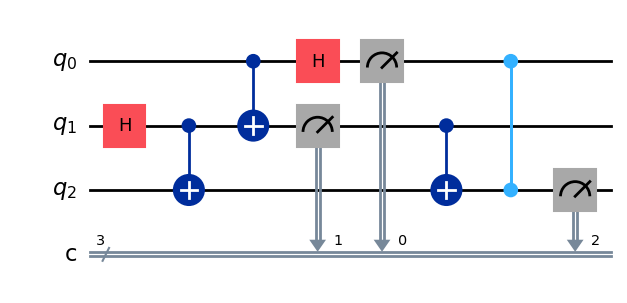

In [2]:
# Import necessary libraries from Qiskit
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Create a quantum circuit with 3 qubits (2 for the entangled pair and 1 for Alice's qubit)
qc = QuantumCircuit(3, 3)

# Step 1: Create an entangled pair between Alice and Bob
qc.h(1)  # Apply Hadamard gate on qubit 1 (Alice's qubit)
qc.cx(1, 2)  # Apply CNOT gate between qubit 1 (control) and qubit 2 (target), creating entanglement

# Step 2: Alice applies a Bell-state measurement on qubits 0 and 1
qc.cx(0, 1)  # Apply CNOT gate between Alice's qubits
qc.h(0)  # Apply Hadamard gate on Alice's qubit

# Step 3: Alice sends classical bits (measurement result) to Bob
qc.measure([0, 1], [0, 1])  # Measure Alice's qubits (0 and 1)

# Step 4: Bob applies the corresponding gates based on Alice's classical bits
qc.cx(1, 2)  # Apply CNOT gate (based on Alice's classical bit 0)
qc.cz(0, 2)  # Apply CZ gate (based on Alice's classical bit 1)

# Step 5: Measure Bob's qubit (2)
qc.measure(2, 2)

# Step 6: Simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(qc,shots=1024).result()
counts = result.get_counts(qc)

# Plot the results
plot_histogram(counts)

# Draw the quantum circuit
qc.draw('mpl')


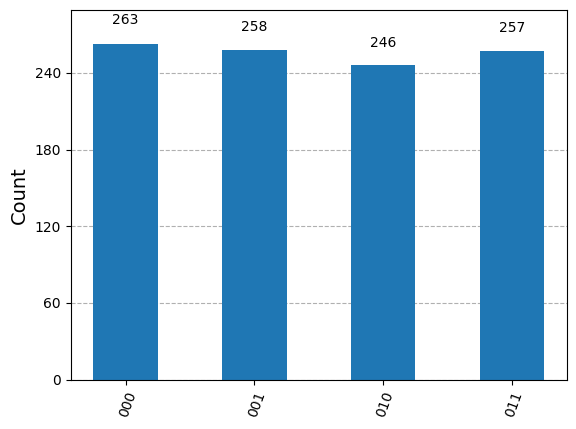

In [3]:
plot_histogram(counts)

In [20]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit_aer import Aer
import matplotlib.pyplot as plt

# Initialize the Quantum Markov Chain
def initialize_state(prob0, prob1):
    """
    Initialize the quantum state with given probabilities.
    Args:
    - prob0: Probability of state 0
    - prob1: Probability of state 1
    Returns:
    - QuantumCircuit object
    """
    qc = QuantumCircuit(1)
    theta = 2 * np.arccos(np.sqrt(prob0))  # Calculate angle for Ry rotation
    qc.ry(theta, 0)
    return qc

# Define the Quantum Transition Operator
def quantum_markov_step(p_matrix):
    """
    Create a quantum transition circuit for the Markov step.
    Args:
    - p_matrix: 2x2 transition matrix
    Returns:
    - QuantumCircuit object
    """
    qc = QuantumCircuit(1)
    p00, p01 = p_matrix[0]
    theta = 2 * np.arccos(np.sqrt(p00))
    qc.ry(theta, 0)  # Ry gate to represent transition
    return qc

# Simulate the Quantum Markov Chain
def simulate_qmc(initial_probs, p_matrix, steps):
    """
    Simulate the Quantum Markov Chain.
    Args:
    - initial_probs: List of initial probabilities [p0, p1]
    - p_matrix: Transition matrix
    - steps: Number of steps to simulate
    Returns:
    - Final state probabilities
    """
    qc = initialize_state(*initial_probs)
    step_circuit = quantum_markov_step(p_matrix)
    for _ in range(steps):
        qc.compose(step_circuit, inplace=True)

    qc.measure_all()
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc, simulator)
    results = simulator.run(compiled_circuit,shots=1000).result()
    counts = results.get_counts()
    qc.draw('mpl')
    return counts


# Example: Parameters for the QMC
initial_probs = [0.8, 0.2]  # Initial state probabilities
transition_matrix = [[0.7, 0.3], [0.4, 0.6]]  # 2x2 Transition matrix
steps = 3  # Number of steps to simulate

# Run Simulation
counts = simulate_qmc(initial_probs, transition_matrix, steps)

# Visualize Results
print("Final Measurement Counts:", counts)
plot_histogram(counts)
plt.show()


Final Measurement Counts: {'0': 353, '1': 647}


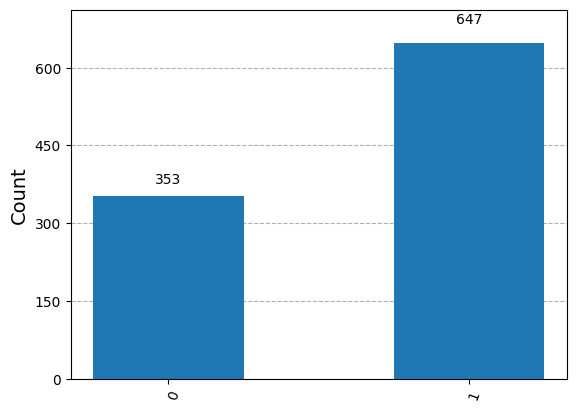

In [21]:
plot_histogram(counts)

In [1]:
import hashlib

# Function to generate a hash value for a given message
def generate_hash(message):
    return hashlib.sha256(message.encode()).hexdigest()

# Simulate Alice's and Bob's communication using a secure protocol
def secure_communication():
    # Initial messages
    alice_message = "Quantum secure data from Alice to Bob"
    bob_message = "Acknowledgment from Bob to Alice"

    print("Step 1: Alice prepares a secure message.")
    print(f"Alice's Message: {alice_message}")
    
    # Eavesdrop attempt 1: Before communication starts
    print("\nEavesdrop Attempt 1: Before Communication")
    eve_hash_1 = generate_hash(alice_message)
    print(f"Eve's Hash Value Before Communication: {eve_hash_1}")

    # Communication between Alice and Bob with encapsulated message
    print("\nStep 2: BB84 communication between Alice and Bob begins.")
    encapsulated_message = generate_hash(alice_message)  # Encapsulate with hash function

    # Eavesdrop attempt 2: During communication
    print("\nEavesdrop Attempt 2: During Communication")
    eve_hash_2 = encapsulated_message
    print(f"Eve's Hash Value During Communication: {eve_hash_2}")

    print("\nStep 3: Bob receives the message and verifies the hash.")
    bob_received_message = alice_message
    bob_hash = generate_hash(bob_received_message)
    print(f"Bob's Hash Value: {bob_hash}")

    # Verification at Bob's end
    if bob_hash == encapsulated_message:
        print("Verification Successful: Message integrity is maintained.")
    else:
        print("Verification Failed: Message has been tampered with.")

    # Eavesdrop attempt 3: After communication ends
    print("\nEavesdrop Attempt 3: After Communication")
    eve_hash_3 = generate_hash(bob_message)  # Eve captures Bob's response
    print(f"Eve's Hash Value After Communication: {eve_hash_3}")

    print("\nStep 4: Secure communication completed between Alice and Bob.")

# Run the simulation
secure_communication()


Step 1: Alice prepares a secure message.
Alice's Message: Quantum secure data from Alice to Bob

Eavesdrop Attempt 1: Before Communication
Eve's Hash Value Before Communication: 608be062c3b2b60e8bf32f26507daee7595773fa6b1d3a0a2004fdb696953074

Step 2: BB84 communication between Alice and Bob begins.

Eavesdrop Attempt 2: During Communication
Eve's Hash Value During Communication: 608be062c3b2b60e8bf32f26507daee7595773fa6b1d3a0a2004fdb696953074

Step 3: Bob receives the message and verifies the hash.
Bob's Hash Value: 608be062c3b2b60e8bf32f26507daee7595773fa6b1d3a0a2004fdb696953074
Verification Successful: Message integrity is maintained.

Eavesdrop Attempt 3: After Communication
Eve's Hash Value After Communication: dff23fa8e97014e663f0feb774587efee43f2ee3c6c9c5d1ca7c4d5ad6ec1927

Step 4: Secure communication completed between Alice and Bob.


In [27]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
import hashlib

# Function to generate a hash value for a given message
def generate_hash(message):
    return hashlib.sha256(message.encode()).hexdigest()

# Function to decode Bob's received bits into a readable message
def bob_retrieve_message(results, message_length):
    decoded_bits = list(results.keys())[0]  # Get the bitstring from the measurement results
    decoded_message = ""
    for i in range(0, len(decoded_bits), 8):  # Process in chunks of 8 bits (1 byte)
        byte = decoded_bits[i:i + 8]
        decoded_char = chr(int(byte, 2)) if len(byte) == 8 else ""
        decoded_message += decoded_char
    return decoded_message[:message_length]

# BB84 Protocol-like Communication using Qiskit
def bb84_secure_communication():
    # Backend simulator
    backend = Aer.get_backend('qasm_simulator')

    # Alice's message
    alice_message = ":)"
    message_length = len(alice_message)

    print(f"Alice's Message: {alice_message}")

    # Eavesdrop attempt 1: Before communication starts
    print("\nEavesdrop Attempt 1: Before Communication")
    eve_hash_1 = generate_hash(alice_message)
    print(f"Eve's Hash Value: {eve_hash_1}")

    # Step 2: BB84 communication begins
    
    num_qubits = len(alice_message) * 8  # Ensure 8 qubits per character

    # Alice prepares quantum states
    alice_circuit = QuantumCircuit(num_qubits, num_qubits)
    alice_bases = []  # Random bases for encoding (0 for Z, 1 for X)
    alice_bits = []   # Random bits to encode
    for i in range(num_qubits):
        bit = (ord(alice_message[i // 8]) >> (7 - i % 8)) & 1  # Get each bit of the message
        alice_bits.append(bit)
        alice_bases.append(int(i % 2))  # Alternating bases for demonstration
        if bit == 1:
            alice_circuit.x(i)  # Apply X (bit-flip) if bit is 1
        if alice_bases[-1] == 1:
            alice_circuit.h(i)  # Apply H (Hadamard) for X-basis encoding

    # Eavesdrop attempt 2: During communication
    print("\nEavesdrop Attempt 2: During Communication")
    eve_hash_2 = generate_hash("Quantum data being transferred")
    print(f"Eve's Hash Value: {eve_hash_2}")

    # Bob receives and measures quantum states
    bob_circuit = QuantumCircuit(num_qubits, num_qubits)
    bob_bases = []  # Random bases for decoding
    for i in range(num_qubits):
        bob_bases.append(int((i + 1) % 2))  # Alternating bases for decoding
        if bob_bases[-1] == 1:
            bob_circuit.h(i)  # Apply H for X-basis decoding
        bob_circuit.measure(i, i)

    # Combine Alice's and Bob's circuits
    combined_circuit = alice_circuit.compose(bob_circuit)

    # Execute the quantum circuit
    job = backend.run(combined_circuit, backend=backend, shots=1)
    results = job.result().get_counts()

    
    print("Measurement Results:", results)

    # Bob retrieves and prints the message
    received_message = bob_retrieve_message(results, message_length)
    print(f"Bob's Decoded Message: {received_message}")

    # Verification step
    bob_hash = generate_hash(received_message)
    alice_hash = generate_hash(alice_message)
    if bob_hash == alice_hash:
        print("Verification Successful: Message integrity is maintained.")
    else:
        print("Verification Failed: Message has been tampered with.")

    # Eavesdrop attempt 3: After communication ends
    print("\nEavesdrop Attempt 3: After Communication")
    eve_hash_3 = generate_hash("Bob's acknowledgment message")
    print(f"Eve's Hash Value: {eve_hash_3}")

    
    return bob_circuit
# Run the Qiskit BB84 simulation
bb84_secure_communication().draw()


Alice's Message: :)

Eavesdrop Attempt 1: Before Communication
Eve's Hash Value: 54d626e08c1c802b305dad30b7e54a82f102390cc92c7d4db112048935236e9c

Eavesdrop Attempt 2: During Communication
Eve's Hash Value: 4a68dd875be9ddde22f62d244dd67023fe4cc1284daba272b94e39977adf4e13
Measurement Results: {'0011011111010000': 1}
Bob's Decoded Message: 7Ð
Verification Failed: Message has been tampered with.

Eavesdrop Attempt 3: After Communication
Eve's Hash Value: ba46600ab3eb4baabdf75f1d619631225646825d1668e8844fcb363ba49bffaf


┌───┐                                   ┌─┐                     
 q_0: ┤ H ├───────────────────────────────────┤M├─────────────────────
      └┬─┬┘                                   └╥┘                     
 q_1: ─┤M├─────────────────────────────────────╫──────────────────────
       └╥┘ ┌───┐                               ║ ┌─┐                  
 q_2: ──╫──┤ H ├───────────────────────────────╫─┤M├──────────────────
        ║  └┬─┬┘                               ║ └╥┘                  
 q_3: ──╫───┤M├────────────────────────────────╫──╫───────────────────
        ║   └╥┘ ┌───┐                          ║  ║ ┌─┐               
 q_4: ──╫────╫──┤ H ├──────────────────────────╫──╫─┤M├───────────────
        ║    ║  └┬─┬┘                          ║  ║ └╥┘               
 q_5: ──╫────╫───┤M├───────────────────────────╫──╫──╫────────────────
        ║    ║   └╥┘ ┌───┐                     ║  ║  ║ ┌─┐            
 q_6: ──╫────╫────╫──┤ H ├─────────────────────╫──╫──╫─┤M├────────────
        ║    ║    ║  └┬─┬┘                     ║  ║  ║ └╥┘            
 q_7: ──╫────╫────╫───┤M├──────────────────────╫──╫──╫──╫─────────────
        ║    ║    ║   └╥┘ ┌───┐                ║  ║  ║  ║ ┌─┐         
 q_8: ──╫────╫────╫────╫──┤ H ├────────────────╫──╫──╫──╫─┤M├─────────
        ║    ║    ║    ║  └┬─┬┘                ║  ║  ║  ║ └╥┘         
 q_9: ──╫────╫────╫────╫───┤M├─────────────────╫──╫──╫──╫──╫──────────
        ║    ║    ║    ║   └╥┘ ┌───┐           ║  ║  ║  ║  ║ ┌─┐      
q_10: ──╫────╫────╫────╫────╫──┤ H ├───────────╫──╫──╫──╫──╫─┤M├──────
        ║    ║    ║    ║    ║  └┬─┬┘           ║  ║  ║  ║  ║ └╥┘      
q_11: ──╫────╫────╫────╫────╫───┤M├────────────╫──╫──╫──╫──╫──╫───────
        ║    ║    ║    ║    ║   └╥┘ ┌───┐      ║  ║  ║  ║  ║  ║ ┌─┐   
q_12: ──╫────╫────╫────╫────╫────╫──┤ H ├──────╫──╫──╫──╫──╫──╫─┤M├───
        ║    ║    ║    ║    ║    ║  └┬─┬┘      ║  ║  ║  ║  ║  ║ └╥┘   
q_13: ──╫────╫────╫────╫────╫────╫───┤M├───────╫──╫──╫──╫──╫──╫──╫────
        ║    ║    ║    ║    ║    ║   └╥┘ ┌───┐ ║  ║  ║  ║  ║  ║  ║ ┌─┐
q_14: ──╫────╫────╫────╫────╫────╫────╫──┤ H ├─╫──╫──╫──╫──╫──╫──╫─┤M├
        ║    ║    ║    ║    ║    ║    ║  └┬─┬┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
q_15: ──╫────╫────╫────╫────╫────╫────╫───┤M├──╫──╫──╫──╫──╫──╫──╫──╫─
        ║    ║    ║    ║    ║    ║    ║   └╥┘  ║  ║  ║  ║  ║  ║  ║  ║ 
c: 16/══╩════╩════╩════╩════╩════╩════╩════╩═══╩══╩══╩══╩══╩══╩══╩══╩═
        1    3    5    7    9    11   13   15  0  2  4  6  8  10 12 14

In [6]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
import random


def generate_random_bits_and_bases(num_bits):
    """Generate random bits and bases (Z or X) for Alice or Bob."""
    bits = [random.randint(0, 1) for _ in range(num_bits)]
    bases = [random.randint(0, 1) for _ in range(num_bits)]  # 0 for Z basis, 1 for X basis
    return bits, bases


def prepare_qubits(bits, bases):
    """Prepare qubits in the BB84 protocol based on bits and bases."""
    num_qubits = len(bits)
    qc = QuantumCircuit(num_qubits, num_qubits)

    for i in range(num_qubits):
        if bits[i] == 1:
            qc.x(i)  # Encode bit 1 as |1⟩
        if bases[i] == 1:
            qc.h(i)  # Apply Hadamard for X basis

    return qc


def measure_qubits(qc, bases):
    """Measure qubits in the given basis (Z or X)."""
    num_qubits = len(bases)
    for i in range(num_qubits):
        if bases[i] == 1:  # Measure in X basis
            qc.h(i)
        qc.measure(i, i)
    return qc


def sift_keys(alice_bits, alice_bases, bob_bases, results):
    """Sift the key: Keep only the bits where Alice and Bob's bases match."""
    sifted_key = []
    for i in range(len(alice_bits)):
        if alice_bases[i] == bob_bases[i]:
            sifted_key.append(int(results[i]))

    return sifted_key


def simulate_bb84(num_bits=10):
    """Simulate the BB84 protocol."""
    print(f"Simulating BB84 protocol with {num_bits} qubits...\n")

    # Step 1: Alice generates random bits and bases
    alice_bits, alice_bases = generate_random_bits_and_bases(num_bits)
    print(f"Alice's bits:   {alice_bits}")
    print(f"Alice's bases:  {alice_bases} (0=Z, 1=X)\n")

    # Step 2: Alice prepares qubits and sends them to Bob
    alice_circuit = prepare_qubits(alice_bits, alice_bases)

    # Step 3: Bob generates random bases and measures the qubits
    bob_bases = [random.randint(0, 1) for _ in range(num_bits)]
    print(f"Bob's bases:    {bob_bases} (0=Z, 1=X)\n")

    # Bob measures the qubits in his random bases
    bob_circuit = measure_qubits(alice_circuit.copy(), bob_bases)

    # Execute the circuit
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(bob_circuit, shots=1)
    results = job.result().get_counts()

    # Extract Bob's measurement results as a bitstring
    result_key = list(results.keys())[0]
    bob_measurements = [int(bit) for bit in result_key]
    print(f"Bob's measurements: {bob_measurements}\n")

    # Step 4: Sift the key (retain bits where bases match)
    sifted_key = sift_keys(alice_bits, alice_bases, bob_bases, bob_measurements)
    print(f"Sifted key: {sifted_key}")

    # Optional: Compare and simulate reconciliation (error correction or privacy amplification)
    print("\nKey agreement complete.")
    return sifted_key


# Run the BB84 simulation
final_key = simulate_bb84(num_bits=10)
print(f"\nFinal shared key: {final_key}")


Simulating BB84 protocol with 10 qubits...

Alice's bits:   [0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Alice's bases:  [1, 1, 0, 0, 0, 1, 0, 1, 1, 0] (0=Z, 1=X)

Bob's bases:    [0, 1, 1, 1, 0, 0, 0, 0, 0, 1] (0=Z, 1=X)

Bob's measurements: [1, 1, 1, 0, 0, 1, 1, 1, 0, 0]

Sifted key: [1, 0, 1]

Key agreement complete.

Final shared key: [1, 0, 1]


In [21]:
import random
from qiskit import QuantumCircuit
from qiskit_aer import Aer

def bb84_with_message(message_binary):
    """
    Simulate the BB84 protocol to send a user-defined binary message.
    """

    # Convert the message to a list of bits (0s and 1s)
    message_bits = [int(bit) for bit in message_binary]

    # Step 1: Alice's random bits and bases
    alice_bits = message_bits  # Use the message directly as the data bits
    alice_bases = [random.randint(0, 1) for _ in range(len(alice_bits))]  # Random bases (0=Z, 1=X)

    # Step 2: Bob's random bases
    bob_bases = [random.randint(0, 1) for _ in range(len(alice_bits))]

    # Step 3: Alice sends qubits based on her bits and bases
    backend = Aer.get_backend('aer_simulator')
    alice_circuits = []
    for bit, basis in zip(alice_bits, alice_bases):
        qc = QuantumCircuit(1, 1)
        if basis == 1:  # X-basis
            qc.h(0)
        if bit == 1:
            qc.x(0)
        if basis == 1:  # Apply Hadamard for X-basis after encoding
            qc.h(0)
        alice_circuits.append(qc)

    # Step 4: Bob measures qubits using his random bases
    bob_measurements = []
    for qc, bob_basis in zip(alice_circuits, bob_bases):
        if bob_basis == 1:  # X-basis
            qc.h(0)
        qc.measure(0, 0)
        job = backend.run(qc, backend=backend, shots=1, memory=True)
        result = job.result()
        measurement = int(result.get_memory()[0])
        bob_measurements.append(measurement)

    # Step 5: Compare Alice's and Bob's bases to generate the sifted key
    sifted_key = []
    key_indices = []
    for i, (a_basis, b_basis) in enumerate(zip(alice_bases, bob_bases)):
        if a_basis == b_basis:  # Bases match
            sifted_key.append(alice_bits[i])
            key_indices.append(i)

    # Step 6: Alice encrypts her message with the sifted key
    encrypted_message = [(bit ^ sifted_key[i % len(sifted_key)]) for i, bit in enumerate(message_bits)]

    # Step 7: Bob decrypts the message with the sifted key
    decrypted_message = [(bit ^ sifted_key[i % len(sifted_key)]) for i, bit in enumerate(encrypted_message)]

    # Output all steps
    print("\n--- BB84 Protocol ---")
    print(f"Alice's bits (message): {alice_bits}")
    print(f"Alice's bases:          {alice_bases} (0=Z, 1=X)")
    print(f"Bob's bases:            {bob_bases} (0=Z, 1=X)")
    print(f"Bob's measurements:     {bob_measurements}")
    print(f"Sifted key:             {sifted_key}")
    print(f"Encrypted message:      {encrypted_message}")
    print(f"Decrypted message:      {decrypted_message}")
    
    # Display the final message received by Bob
    decrypted_message_str = ''.join(map(str, decrypted_message))
    print(f"\nMessage received by Bob: {decrypted_message_str}")
    return qc
# Example usage: User-defined message (binary format)
message = "101010010"  # Replace with your binary message
bb84_with_message(message).draw()



--- BB84 Protocol ---
Alice's bits (message): [1, 0, 1, 0, 1, 0, 0, 1, 0]
Alice's bases:          [0, 1, 0, 0, 0, 1, 0, 0, 1] (0=Z, 1=X)
Bob's bases:            [0, 1, 0, 1, 1, 1, 0, 1, 1] (0=Z, 1=X)
Bob's measurements:     [1, 1, 1, 1, 0, 0, 0, 0, 0]
Sifted key:             [1, 0, 1, 0, 0, 0]
Encrypted message:      [0, 0, 0, 0, 1, 0, 1, 1, 1]
Decrypted message:      [1, 0, 1, 0, 1, 0, 0, 1, 0]

Message received by Bob: 101010010


┌───┐┌───┐┌───┐┌─┐
  q: ┤ H ├┤ H ├┤ H ├┤M├
     └───┘└───┘└───┘└╥┘
c: 1/════════════════╩═
                     0

S1 stake updated to 100
S2 stake updated to 75
S1 successfully mined a new block.
S2 failed to mine a block.
S1 behavior scores 5
S2 behavior scores 4
S1 failed to mine a block.
S2 failed to mine a block.
S1 failed to mine a block.
S2 failed to mine a block.
S1 failed to mine a block.
S2 failed to mine a block.
S1 successfully mined a new block.
S2 failed to mine a block.
S1 failed to mine a block.
S2 failed to mine a block.
S1 failed to mine a block.
S2 failed to mine a block.
S1 failed to mine a block.
S2 failed to mine a block.
S1 successfully mined a new block.
S2 has been penalized for misbehaving and cannot mine a block.
S1 successfully mined a new block.
S2 has been penalized for misbehaving and cannot mine a block.
S1 successfully mined a new block.
S2 has been penalized for misbehaving and cannot mine a block.
S1 failed to mine a block.
S2 has been penalized for misbehaving and cannot mine a block.
S1 failed to mine a block.
S2 has been penalized for misbehaving and cannot min

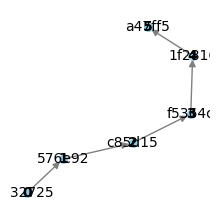

In [47]:
import hashlib
import random
import networkx as nx
import matplotlib.pyplot as plt

# Block class to represent a block in the blockchain
class Block:
    def __init__(self, index, previous_hash, stake, miner):
        self.index = index
        self.previous_hash = previous_hash
        self.hash = self.calculate_hash(stake, miner)
        self.stake = stake
        self.miner = miner

    def calculate_hash(self, stake, miner):
        # Simple hash function combining stake and miner identity
        return hashlib.sha256(f"{self.index}{self.previous_hash}{stake}{miner}".encode('utf-8')).hexdigest()

# Blockchain class
class Blockchain:
    def __init__(self):
        self.chain = [self.create_genesis_block()]
        self.current_index = 1
        self.stakes = {'S1': 100, 'S2': 75}
        self.behavior_scores = {'S1': 5, 'S2': 5}
        self.penalty_threshold = -2  # Penalty score below which a miner can't mine

    def create_genesis_block(self):
        return Block(0, "0", 0, "Genesis")

    def mine_block(self, miner):
        stake = self.stakes[miner]
        behavior_score = self.behavior_scores[miner]

        # Check if miner can mine based on behavior score
        if behavior_score < self.penalty_threshold:
            print(f"{miner} has been penalized for misbehaving and cannot mine a block.")
            return None

        # Simulate the chance of mining a block based on stake
        mining_chance = random.random() * stake / sum(self.stakes.values())
        if mining_chance > 0.5:
            print(f"{miner} successfully mined a new block.")
            new_block = Block(self.current_index, self.chain[-1].hash, stake, miner)
            self.chain.append(new_block)
            self.current_index += 1
            return new_block
        else:
            print(f"{miner} failed to mine a block.")
            # Simulate behavior scoring (negative for failing to mine)
            self.behavior_scores[miner] -= 1
            return None

    def print_chain(self):
        for block in self.chain:
            print(f"Block(index={block.index}, hash={block.hash[:10]}..., previous_hash={block.previous_hash[:10]}...)")

    # Function to visualize the blockchain as a graph
    def visualize_blockchain(self):
        G = nx.DiGraph()  # Directed graph to represent the blockchain

        # Add nodes (blocks) to the graph
        for block in self.chain:
            G.add_node(block.index, label=block.hash[:6], miner=block.miner)

        # Add edges between blocks (linking previous_hash to current block)
        for i in range(1, len(self.chain)):
            G.add_edge(self.chain[i-1].index, self.chain[i].index)

        # Set up the plot for visualization
        pos = nx.spring_layout(G)  # Layout for the nodes in the graph
        labels = nx.get_node_attributes(G, 'label')
        
        plt.figure(figsize=(2, 2))
        nx.draw(G, pos, with_labels=True, node_size=30, node_color="skyblue", font_size=10, font_weight='bold', edge_color="gray")
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black')
        plt.show()

# Simulation of the blockchain
def simulate_blockchain():
    blockchain = Blockchain()

    # Simulate Alice and Bob mining
    print(f"S1 stake updated to {blockchain.stakes['S1']}")
    print(f"S2 stake updated to {blockchain.stakes['S2']}")

    # First round of mining
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')

    print(f"S1 behavior scores {blockchain.behavior_scores['S1']}")
    print(f"S2 behavior scores {blockchain.behavior_scores['S2']}")
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    
    # Second round of mining with behavior updates
    blockchain.mine_block('S1')
    blockchain.mine_block('S2')
    print(f"S1 behavior scores {blockchain.behavior_scores['S1']}")
    print(f"S2 behavior scores {blockchain.behavior_scores['S2']}")

    # Print the blockchain
    blockchain.print_chain()

    # Visualize the blockchain
    blockchain.visualize_blockchain()

# Run the simulation
simulate_blockchain()


Alice's stake updated to 100
Bob's stake updated to 50
Alice successfully mined a new block.
Bob failed to mine a block.
Alice behavior scores 0
Bob behavior scores -1
Alice successfully mined a new block.
Bob failed to mine a block.
Alice successfully mined a new block.
Bob failed to mine a block.
Alice failed to mine a block.
Alice successfully mined a new block.
Alice successfully mined a new block.
Alice successfully mined a new block.
Alice failed to mine a block.
Alice failed to mine a block.
Alice behavior scores -3
Bob behavior scores -3
Block(index=0, hash=13272589f8..., previous_hash=0...)
Block(index=1, hash=0e4855bf2f..., previous_hash=13272589f8...)
Block(index=2, hash=71036986c7..., previous_hash=0e4855bf2f...)
Block(index=3, hash=5c7fe7886a..., previous_hash=71036986c7...)
Block(index=4, hash=e1c7d732f2..., previous_hash=5c7fe7886a...)
Block(index=5, hash=4d0df9590b..., previous_hash=e1c7d732f2...)
Block(index=6, hash=de0600c9d1..., previous_hash=4d0df9590b...)


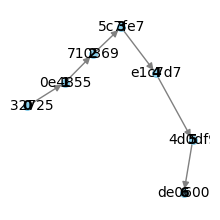

In [133]:
import hashlib
import random
import networkx as nx
import matplotlib.pyplot as plt

# Block class to represent a block in the blockchain
class Block:
    def __init__(self, index, previous_hash, stake, miner):
        self.index = index
        self.previous_hash = previous_hash
        self.hash = self.calculate_hash(stake, miner)
        self.stake = stake
        self.miner = miner

    def calculate_hash(self, stake, miner):
        # Simple hash function combining stake and miner identity
        return hashlib.sha256(f"{self.index}{self.previous_hash}{stake}{miner}".encode('utf-8')).hexdigest()

# Blockchain class
class Blockchain:
    def __init__(self):
        self.chain = [self.create_genesis_block()]
        self.current_index = 1
        self.stakes = {'Alice': 100, 'Bob': 50}
        self.behavior_scores = {'Alice': 0, 'Bob': 0}
        self.penalty_threshold = -2  # Penalty score below which a miner can't mine

    def create_genesis_block(self):
        return Block(0, "0", 0, "Genesis")

    def mine_block(self, miner):
        stake = self.stakes[miner]
        behavior_score = self.behavior_scores[miner]

        # Check if miner can mine based on behavior score
        if behavior_score < self.penalty_threshold:
            
            return None

        # Simulate the chance of mining a block based on stake
        mining_chance = random.random() * stake / sum(self.stakes.values())
        if mining_chance > 0.5:
            print(f"{miner} successfully mined a new block.")
            new_block = Block(self.current_index, self.chain[-1].hash, stake, miner)
            self.chain.append(new_block)
            self.current_index += 1
            return new_block
        else:
            print(f"{miner} failed to mine a block.")
            # Simulate behavior scoring (negative for failing to mine)
            self.behavior_scores[miner] -= 1
            return None

    def print_chain(self):
        for block in self.chain:
            print(f"Block(index={block.index}, hash={block.hash[:10]}..., previous_hash={block.previous_hash[:10]}...)")

    # Function to visualize the blockchain as a graph
    def visualize_blockchain(self):
        G = nx.DiGraph()  # Directed graph to represent the blockchain

        # Add nodes (blocks) to the graph
        for block in self.chain:
            G.add_node(block.index, label=block.hash[:6], miner=block.miner)

        # Add edges between blocks (linking previous_hash to current block)
        for i in range(1, len(self.chain)):
            G.add_edge(self.chain[i-1].index, self.chain[i].index)

        # Set up the plot for visualization
        pos = nx.spring_layout(G)  # Layout for the nodes in the graph
        labels = nx.get_node_attributes(G, 'label')
        
        plt.figure(figsize=(2, 2))
        nx.draw(G, pos, with_labels=True, node_size=30, node_color="skyblue", font_size=10, font_weight='bold', edge_color="gray")
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black')
        
       
        plt.show()

# Simulation of the blockchain
def simulate_blockchain():
    blockchain = Blockchain()

    # Simulate Alice and Bob mining
    print(f"Alice's stake updated to {blockchain.stakes['Alice']}")
    print(f"Bob's stake updated to {blockchain.stakes['Bob']}")

    # First round of mining
    blockchain.mine_block('Alice')
    blockchain.mine_block('Bob')

    print(f"Alice behavior scores {blockchain.behavior_scores['Alice']}")
    print(f"Bob behavior scores {blockchain.behavior_scores['Bob']}")
    for i in range(0,100):
     blockchain.mine_block('Alice')
     blockchain.mine_block('Bob')
    
    # Second round of mining with behavior updates
    blockchain.mine_block('Alice')
    blockchain.mine_block('Bob')
    print(f"Alice behavior scores {blockchain.behavior_scores['Alice']}")
    print(f"Bob behavior scores {blockchain.behavior_scores['Bob']}")

    # Print the blockchain
    blockchain.print_chain()

    # Visualize the blockchain
    blockchain.visualize_blockchain()

# Run the simulation
simulate_blockchain()


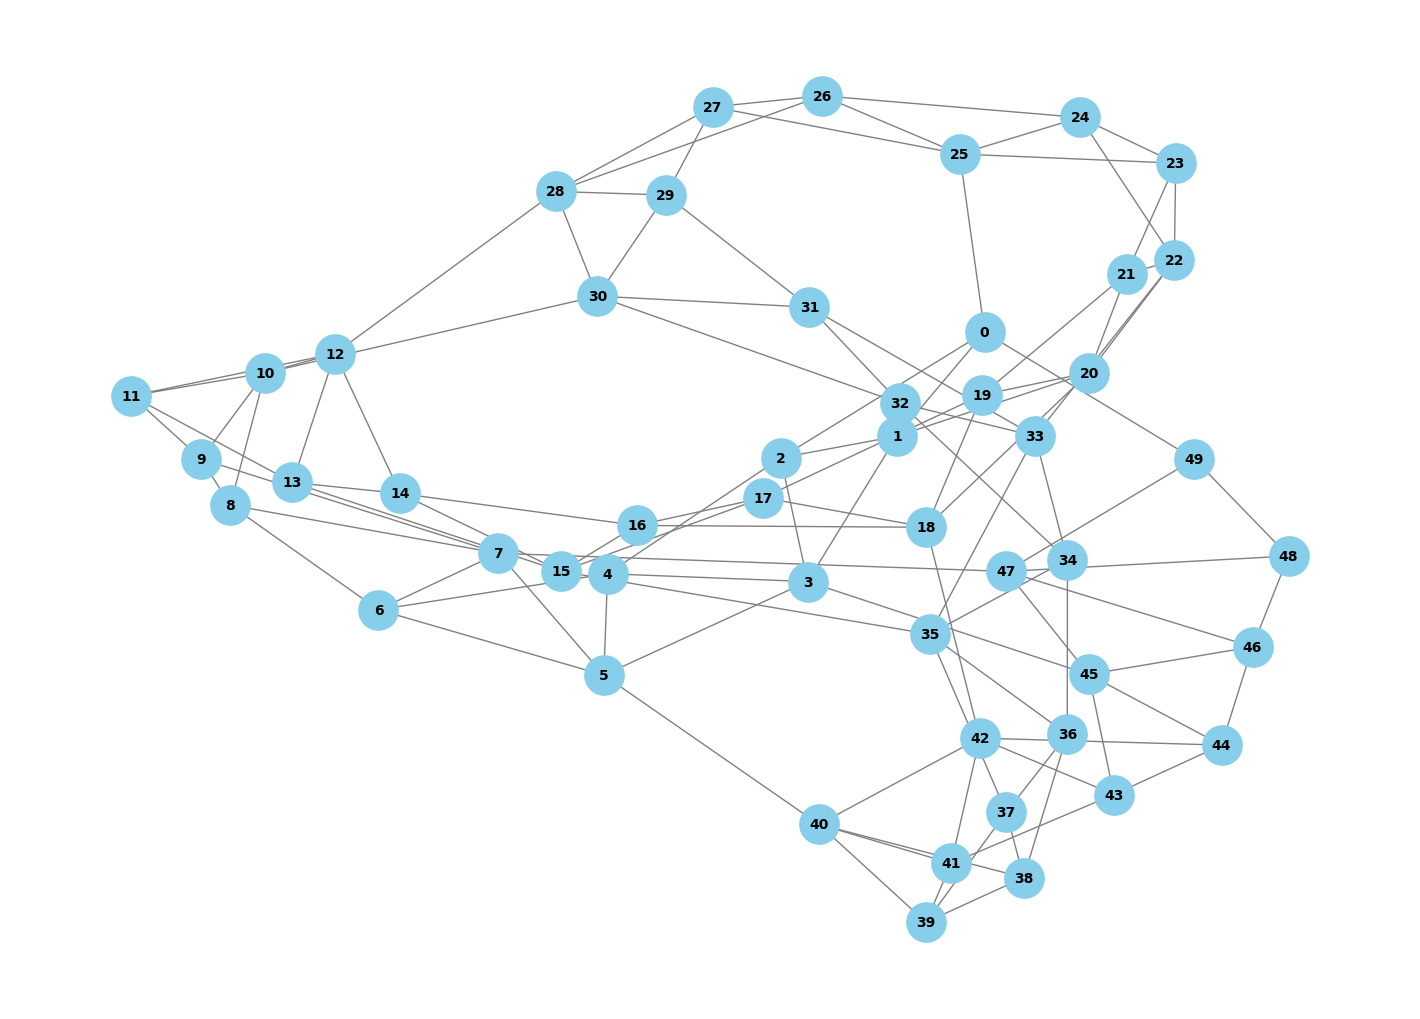

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a larger multi-agent QAOA network with 50 agents
agents_complex = 50  # Number of agents

# Generate edges to form a circular connection
edges_complex = [(i, (i + 1) % agents_complex) for i in range(agents_complex)]

# Add additional inner connections
for i in range(agents_complex):
    if (i + 2) < agents_complex:
        edges_complex.append((i, i + 2))  # Connect to the second neighbor

# Add random connections to increase complexity
random_connections = [
    (0, 25), (1, 20), (10, 30), (15, 35), (5, 40),
    (12, 28), (22, 33), (18, 42), (7, 47), (3, 45)
]
edges_complex.extend(random_connections)

# Create the graph
G_complex = nx.Graph()
G_complex.add_nodes_from(range(agents_complex))
G_complex.add_edges_from(edges_complex)

# Position the nodes using spring layout for better visualization
pos_complex = nx.spring_layout(G_complex)

# Draw the graph with labels for nodes
plt.figure(figsize=(14, 10))
nx.draw(G_complex, pos_complex, with_labels=True, node_size=800, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")

# Add a title to the graph

plt.show()


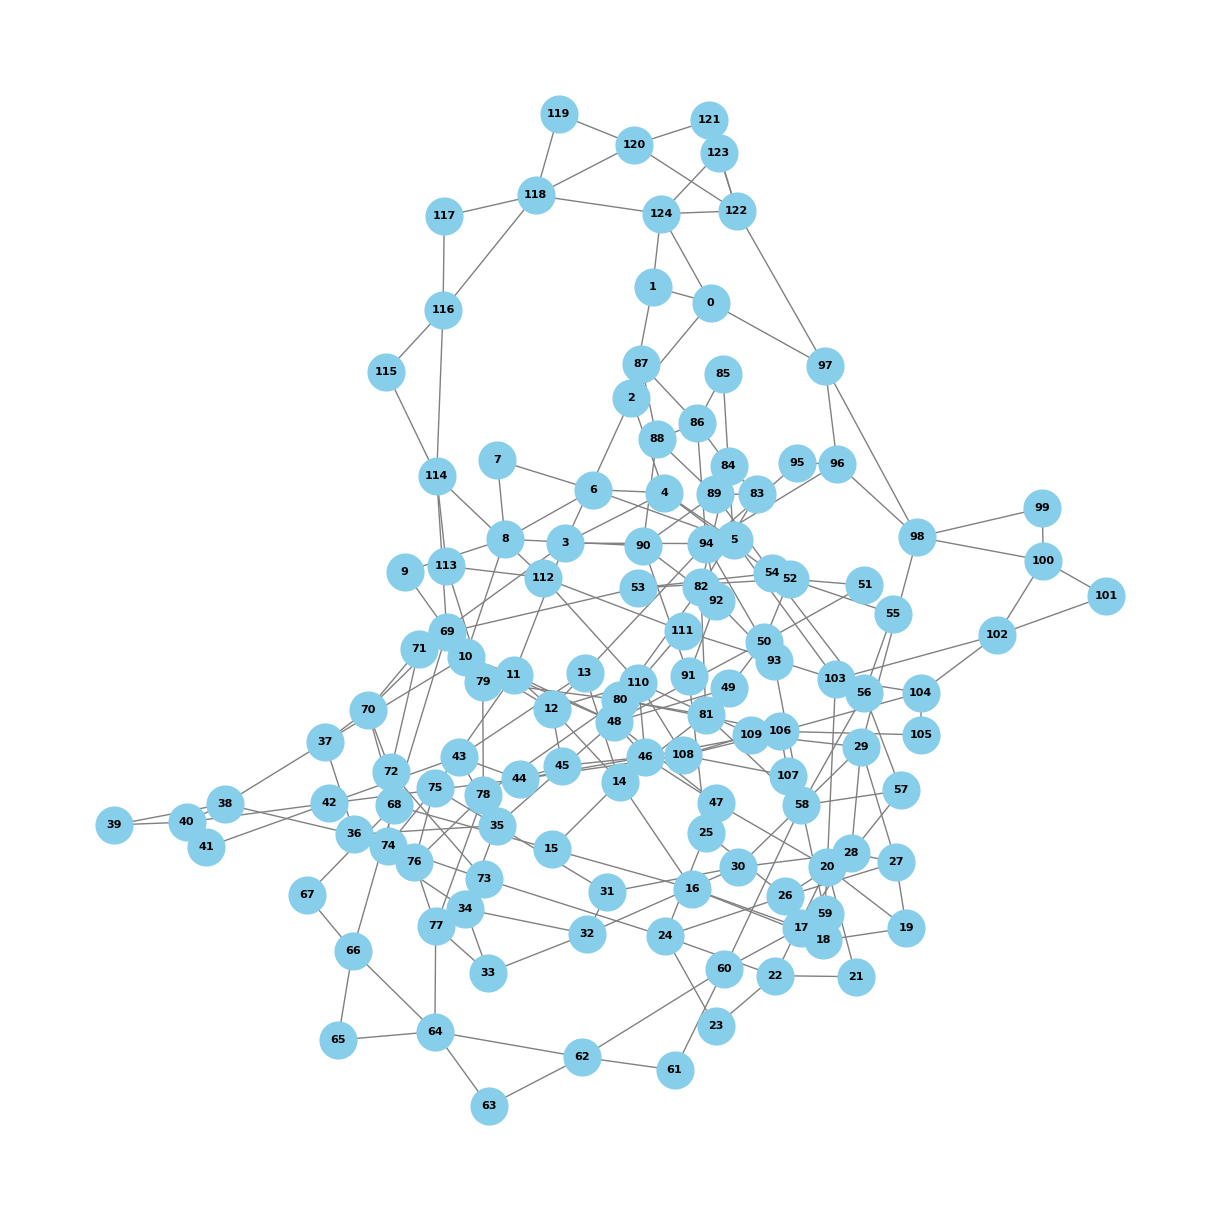

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Number of agents
agents_complex = 125

# Create circular connections
edges_complex = [(i, (i + 1) % agents_complex) for i in range(agents_complex)]

# Add additional inner connections
for i in range(agents_complex):
    if i % 2 == 0:  # Connect every alternate node to its second next neighbor
        edges_complex.append((i, (i + 2) % agents_complex))

# Add random connections to increase complexity
random.seed(42)  # Set seed for reproducibility
random_edges = [(random.randint(0, agents_complex - 1), random.randint(0, agents_complex - 1)) for _ in range(50)]

# Ensure no self-loops and unique edges
random_edges = [(u, v) for u, v in random_edges if u != v]
random_edges = list(set((min(u, v), max(u, v)) for u, v in random_edges))

edges_complex.extend(random_edges)

# Create the graph
G_complex = nx.Graph()
G_complex.add_nodes_from(range(agents_complex))
G_complex.add_edges_from(edges_complex)

# Position the nodes using spring layout for better visualization
pos_complex = nx.spring_layout(G_complex)

# Draw the graph with labels for nodes
plt.figure(figsize=(12, 12))
nx.draw(
    G_complex,
    pos_complex,
    with_labels=True,
    node_size=700,
    node_color="skyblue",
    font_size=8,
    font_weight="bold",
    edge_color="gray"
)

# Add a title to the graph

plt.show()


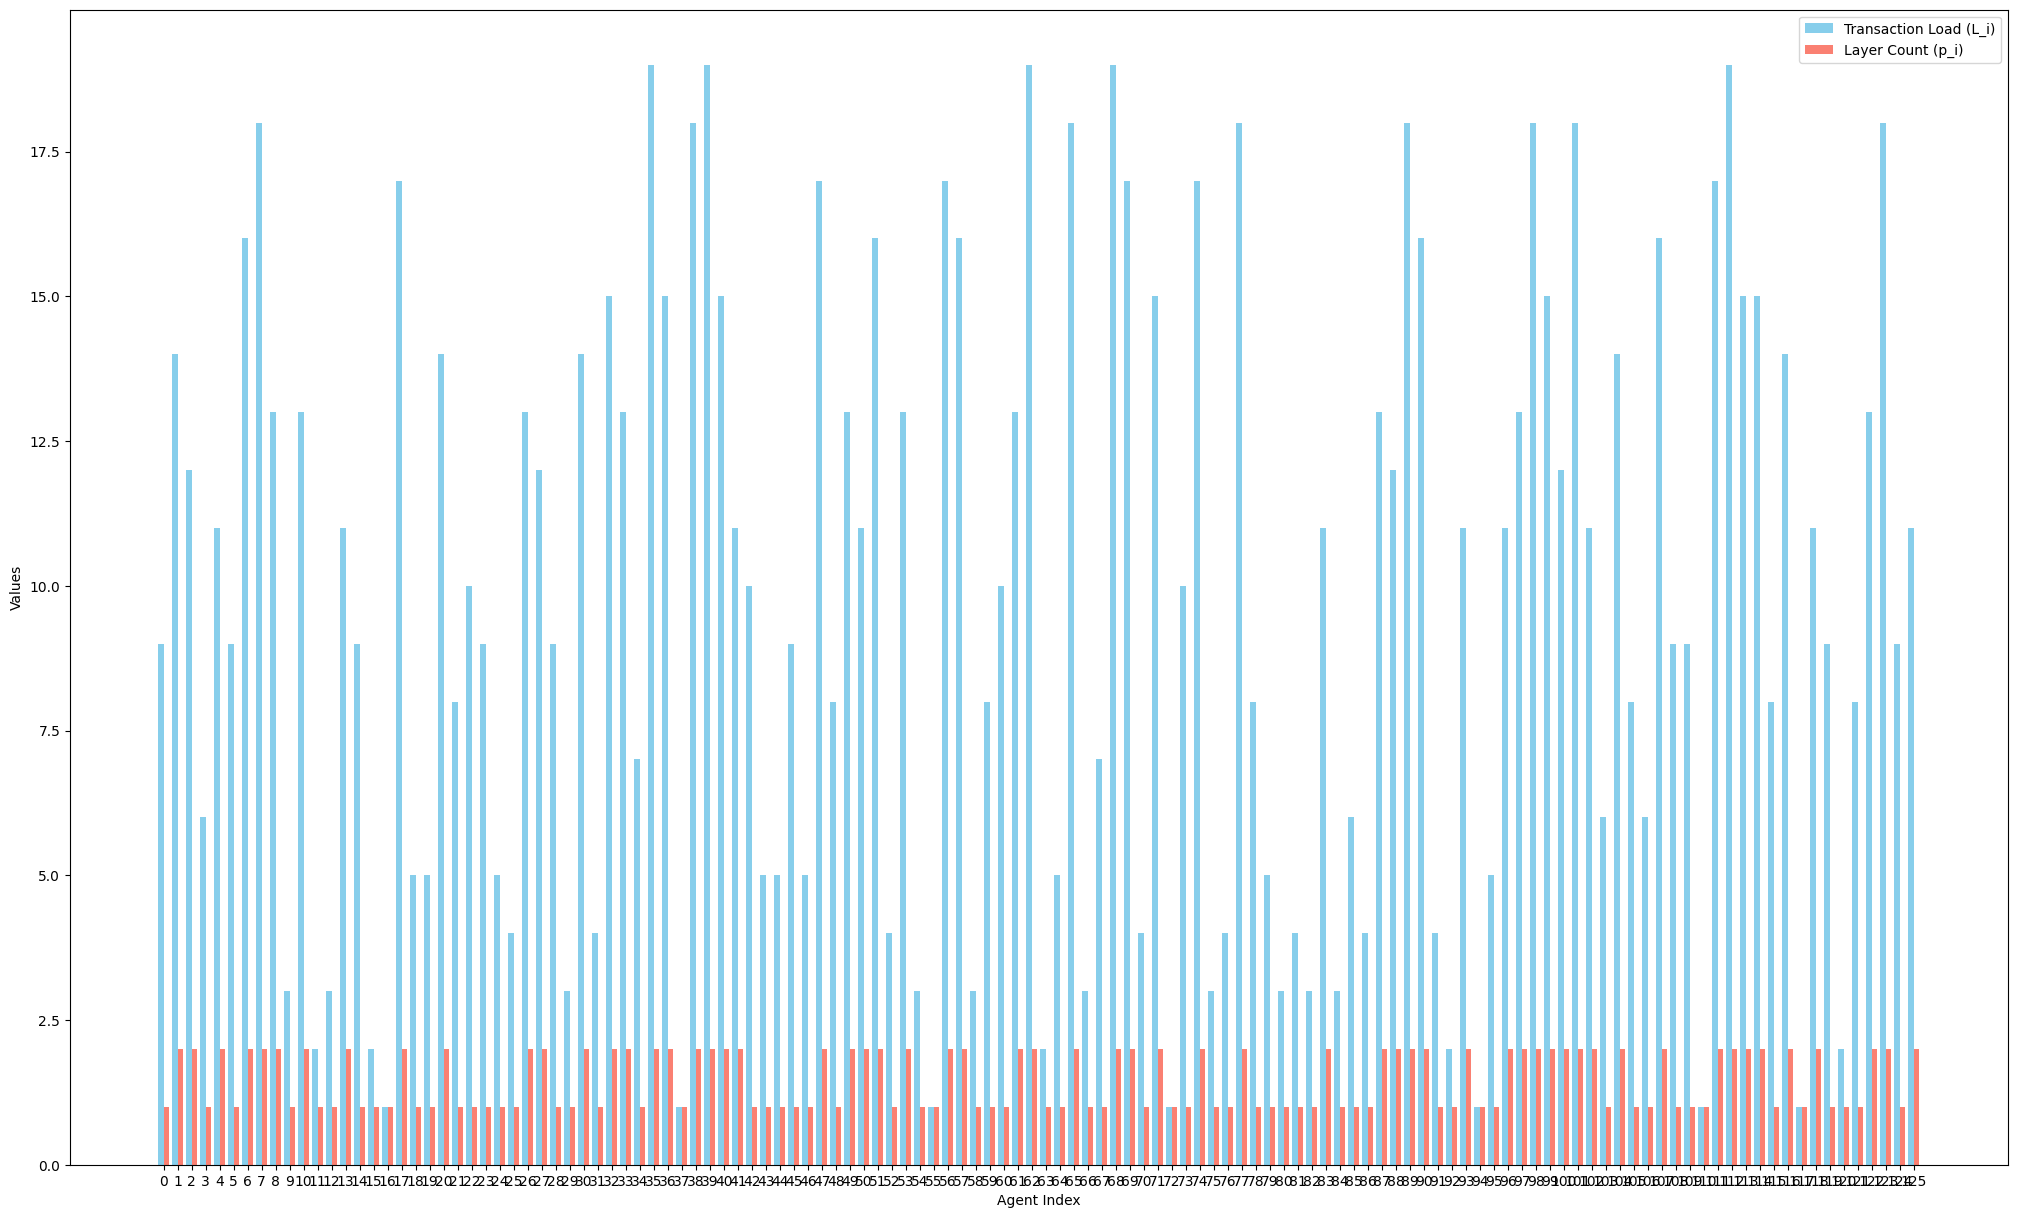

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simulation for Adaptive Layer QAOA mechanism
# Define transaction load (L_i) for each agent and corresponding layer count (p_i)
agents = 126
transaction_loads = np.random.randint(1, 20, size=agents)  # Random transaction loads for each agent
threshold = 10  # Threshold for adding layers
alpha = 1.0  # Scaling factor for layer adjustment
p_max = 5  # Maximum layers

# Calculate the number of layers for each agent based on the load
layer_count = np.minimum(p_max, np.ceil(alpha * transaction_loads / threshold).astype(int))

# Create a bar plot for transaction load vs layer count
plt.figure(figsize=(25, 15))
x = np.arange(agents)
plt.bar(x, transaction_loads, width=0.4, label="Transaction Load (L_i)", color="skyblue", align="center")
plt.bar(x + 0.4, layer_count, width=0.4, label="Layer Count (p_i)", color="salmon", align="center")

# Add labels and title
plt.xlabel("Agent Index")
plt.ylabel("Values")
plt.xticks(x + 0.2, [f"{i}" for i in x])
plt.legend()

# Show the plot
plt.show()


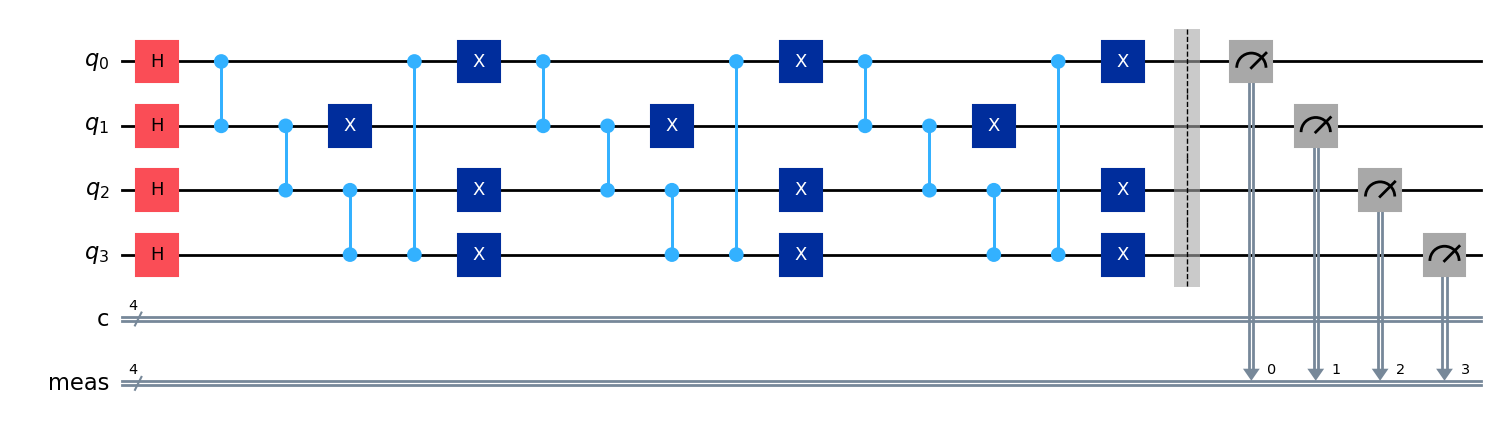

In [12]:
# Import necessary libraries
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Define a quantum circuit for HQAOA
def hqaoa_circuit(num_qubits, p):
    circuit = QuantumCircuit(num_qubits,num_qubits)

    # Initialize qubits to |+> state
    circuit.h(range(num_qubits))

    # Apply alternating layers of cost and mixer Hamiltonians
    for layer in range(p):
        # Cost Hamiltonian: Use Z-gates or other operations based on the problem
        for qubit in range(num_qubits):
            circuit.cz(qubit, (qubit + 1) % num_qubits)

        # Mixer Hamiltonian: X-gates to mix the qubits
        for qubit in range(num_qubits):
            circuit.x(qubit)

    # Add measurements
    circuit.measure_all()

    return circuit

# Example parameters
num_qubits = 4  # Number of qubits (agents)
p = 3  # Number of layers (depth of the circuit)

# Create the quantum circuit
circuit = hqaoa_circuit(num_qubits, p)

# Plot the circuit
circuit.draw('mpl')


# To execute the circuit, you can run it on a simulator





In [14]:
simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(circuit, shots=1024).result()
counts = result.get_counts()
plt.show(counts)


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for simulation
transaction_loads = np.linspace(1, 20, 20)  # Simulated transaction loads (e.g., number of transactions)
layers = np.linspace(1, 10, 10)  # Number of quantum layers
quantum_noise = np.linspace(0, 1, 10)  # Simulating quantum noise levels (0 = no noise, 1 = high noise)

# Performance of QAOA (assuming performance decreases with increasing transaction load and noise)
qaoa_performance = np.exp(-quantum_noise) * np.log(layers) * np.sqrt(transaction_loads)

# Performance of HQAOA (HQAOA adapts to load and adjusts layers dynamically, hence better performance)
hqaoa_performance = np.exp(-quantum_noise) * np.log(layers / 2) * np.sqrt(transaction_loads * 0.9)

# Plotting comparison
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# 1. Transaction Load vs Performance (QAOA vs HQAOA)
ax[0, 0].plot(transaction_loads, qaoa_performance[:len(transaction_loads)], label="QAOA Performance", color="red")
ax[0, 0].plot(transaction_loads, hqaoa_performance[:len(transaction_loads)], label="HQAOA Performance", color="blue")
ax[0, 0].set_xlabel("Transaction Load")
ax[0, 0].set_ylabel("Performance")
ax[0, 0].set_title("Performance vs Transaction Load")
ax[0, 0].legend()

# 2. Quantum Layers vs Performance (QAOA vs HQAOA)
ax[0, 1].plot(layers, qaoa_performance[:len(layers)], label="QAOA Performance", color="red")
ax[0, 1].plot(layers, hqaoa_performance[:len(layers)], label="HQAOA Performance", color="blue")
ax[0, 1].set_xlabel("Number of Layers")
ax[0, 1].set_ylabel("Performance")
ax[0, 1].set_title("Performance vs Number of Layers")
ax[0, 1].legend()

# 3. Quantum Noise vs Performance (QAOA vs HQAOA)
ax[1, 0].plot(quantum_noise, qaoa_performance[:len(quantum_noise)], label="QAOA Performance", color="red")
ax[1, 0].plot(quantum_noise, hqaoa_performance[:len(quantum_noise)], label="HQAOA Performance", color="blue")
ax[1, 0].set_xlabel("Quantum Noise Level")
ax[1, 0].set_ylabel("Performance")
ax[1, 0].set_title("Performance vs Quantum Noise")
ax[1, 0].legend()

# 4. Combined view (Transaction Load, Quantum Layers, Quantum Noise vs Performance)
ax[1, 1].plot(transaction_loads, qaoa_performance[:len(transaction_loads)], label="QAOA", linestyle='--', color="red")
ax[1, 1].plot(transaction_loads, hqaoa_performance[:len(transaction_loads)], label="HQAOA", linestyle='-', color="blue")
ax[1, 1].set_xlabel("Transaction Load")
ax[1, 1].set_ylabel("Performance")
ax[1, 1].set_title("QAOA vs HQAOA Performance Comparison")
ax[1, 1].legend()

# Show the plot
plt.tight_layout()
plt.show()


ValueError: operands could not be broadcast together with shapes (10,) (20,) 

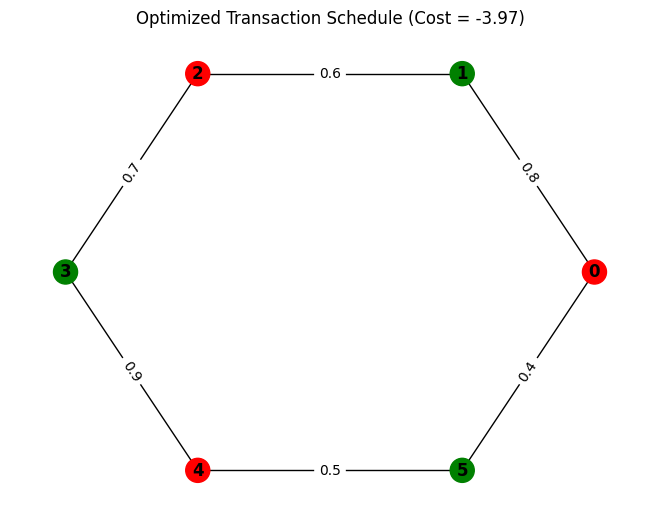

Optimal State: (-1, 1, -1, 1, -1, 1)
Minimum Cost: -3.9651393853022205


In [3]:
import itertools
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Define the graph representing the blockchain network
num_nodes = 6  # Using a smaller number for brute-force
G = nx.Graph()
G.add_nodes_from(range(num_nodes))

# Add weighted edges to simulate dependencies between nodes
edges = [
    (0, 1, 0.8), (1, 2, 0.6), (2, 3, 0.7),
    (3, 4, 0.9), (4, 5, 0.5), (5, 0, 0.4)
]
G.add_weighted_edges_from(edges)

# Local biases for nodes (simulating transaction loads)
local_biases = np.random.uniform(-1, 1, num_nodes)

# Define the cost function
def cost_function(x):
    cost = 0
    for i, j, w in edges:
        cost += w * x[i] * x[j]  # Interaction term
    cost += sum(b * x[i] for i, b in enumerate(local_biases))  # Local biases
    return cost

# Generate all possible states (-1 or 1 for each node)
all_states = list(itertools.product([-1, 1], repeat=num_nodes))

# Find the state that minimizes the cost function
optimal_state = None
min_cost = float('inf')

for state in all_states:
    cost = cost_function(state)
    if cost < min_cost:
        min_cost = cost
        optimal_state = state

# Visualize the graph with optimized node states
pos = nx.circular_layout(G)
colors = ['green' if state == 1 else 'red' for state in optimal_state]
nx.draw(G, pos, with_labels=True, node_color=colors, edge_color='black', font_weight='bold')
weights = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)
plt.title(f"Optimized Transaction Schedule (Cost = {min_cost:.2f})")
plt.show()

# Print the results
print("Optimal State:", optimal_state)
print("Minimum Cost:", min_cost)


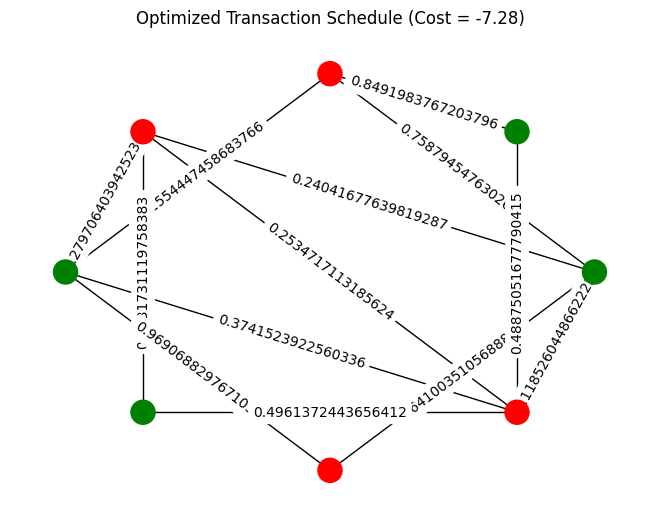

Optimal State: (1, 1, -1, -1, 1, 1, -1, -1)
Minimum Cost: -7.283160303597282


In [31]:
import itertools
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Define the graph representing the blockchain network
num_nodes = 8  # Number of nodes can be adjusted
G = nx.Graph()
G.add_nodes_from(range(num_nodes))

# Add weighted edges to simulate dependencies between nodes with random weights
np.random.seed(42)  # For reproducibility
edges = []
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if np.random.rand() > 0.5:  # Randomly decide if an edge exists
            weight = np.random.uniform(0.1, 1.0)  # Random weight between 0.1 and 1.0
            edges.append((i, j, weight))
G.add_weighted_edges_from(edges)

# Local biases for nodes (simulating transaction loads)
local_biases = np.random.uniform(-1, 1, num_nodes)

# Define the cost function
def cost_function(x):
    cost = 0
    for i, j, w in edges:
        cost += w * x[i] * x[j]  # Interaction term
    cost += sum(b * x[i] for i, b in enumerate(local_biases))  # Local biases
    return cost

# Generate all possible states (-1 or 1 for each node)
all_states = list(itertools.product([-1, 1], repeat=num_nodes))

# Find the state that minimizes the cost function
optimal_state = None
min_cost = float()

for state in all_states:
    cost = cost_function(state)
    if cost < min_cost:
        min_cost = cost
        optimal_state = state

# Visualize the graph with optimized node states
pos = nx.circular_layout(G)
colors = ['green' if state == 1 else 'red' for state in optimal_state]
nx.draw(G, pos, with_labels=False, node_color=colors, edge_color='black', font_weight='bold')
weights = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)
plt.title(f"Optimized Transaction Schedule (Cost = {min_cost:.2f})")
plt.show()

# Print the results
print("Optimal State:", optimal_state)
print("Minimum Cost:", min_cost)

Generating for 10 nodes...


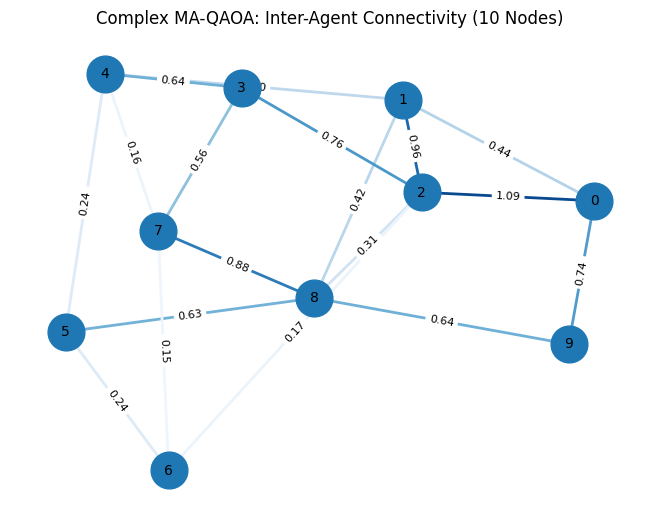

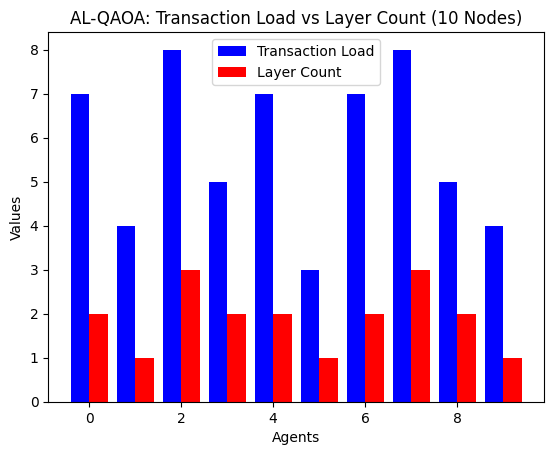

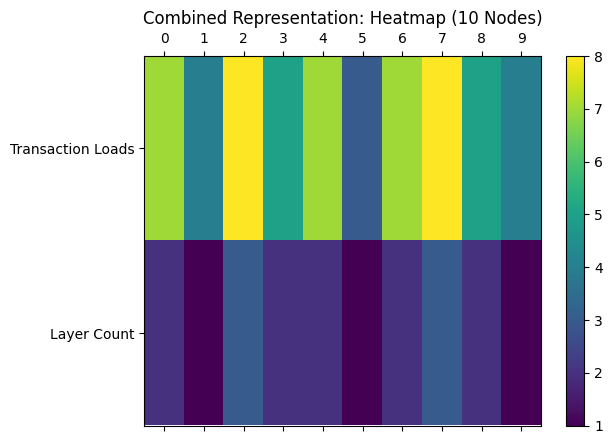

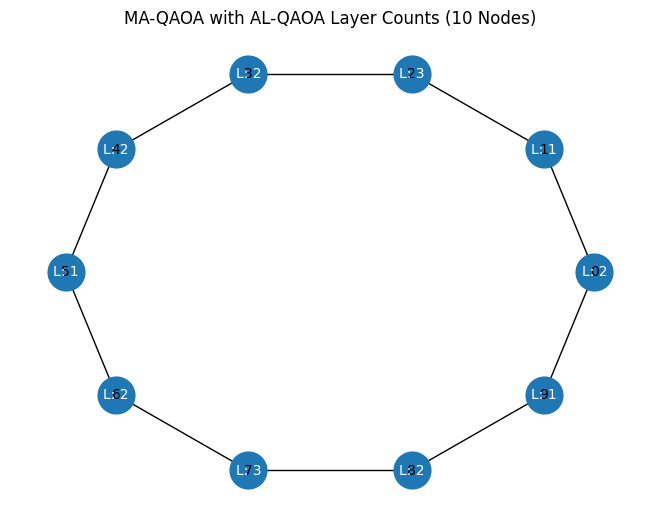

Generating for 15 nodes...


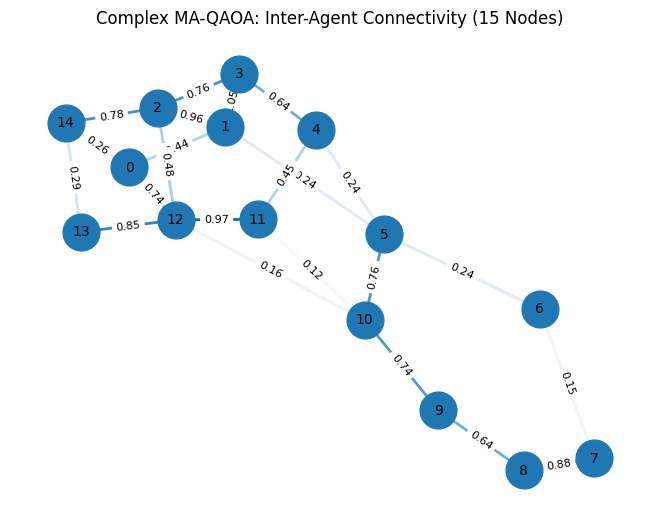

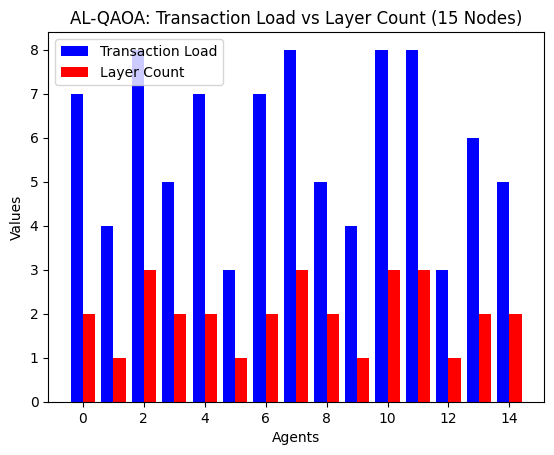

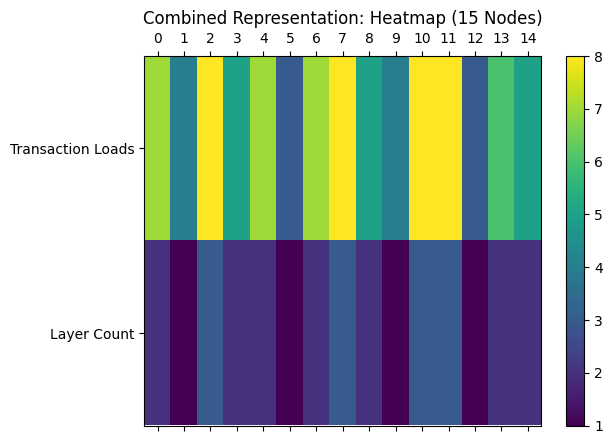

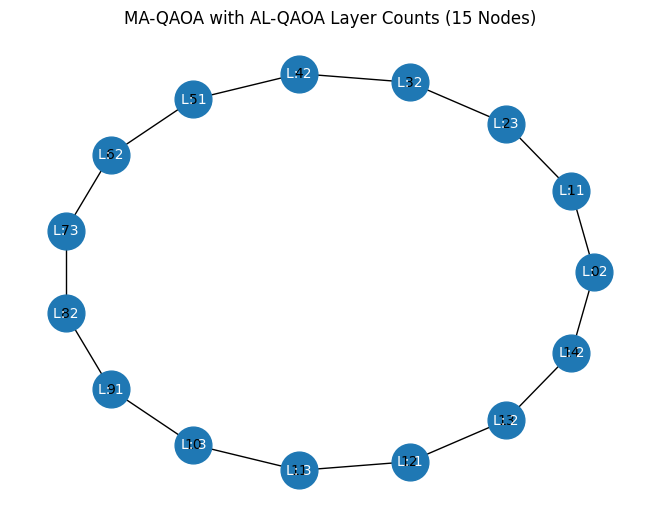

In [37]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Complex MA-QAOA: Inter-Agent Connectivity
def ma_qaoa_complex_graph(num_nodes=10, extra_edges=5, seed=42):
    """
    Creates a complex MA-QAOA graph with circular, inner, and random connections.
    """
    np.random.seed(seed)
    G = nx.Graph()

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add circular edges
    circular_edges = [(i, (i + 1) % num_nodes, {'weight': np.random.uniform(0.1, 1.0)}) for i in range(num_nodes)]
    G.add_edges_from(circular_edges)

    # Add inner edges (non-adjacent nodes)
    inner_edges = []
    while len(inner_edges) < extra_edges:
        u, v = np.random.choice(num_nodes, 2, replace=False)
        if not G.has_edge(u, v) and abs(u - v) > 1:  # Avoid adjacent nodes
            inner_edges.append((u, v, {'weight': np.random.uniform(0.1, 0.8)}))
    G.add_edges_from(inner_edges)

    # Add random edges with a lower probability
    for _ in range(num_nodes):
        if np.random.rand() < 0.3:  # Random chance for additional connections
            u, v = np.random.choice(num_nodes, 2, replace=False)
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=np.random.uniform(0.2, 1.2))

    # Draw the graph
    pos = nx.spring_layout(G, seed=seed)  # Force-directed layout for better visualization
    nx.draw(
        G, pos, with_labels=True, node_size=700, font_size=10,
        edge_color=[d['weight'] for (_, _, d) in G.edges(data=True)],
        edge_cmap=plt.cm.Blues, edge_vmin=0.1, edge_vmax=1.2,
        width=2
    )

    # Add edge labels to show weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(f"Complex MA-QAOA: Inter-Agent Connectivity ({num_nodes} Nodes)")
    plt.show()

# 2. AL-QAOA: Transaction Load vs Layer Count
def al_qaoa_bar_chart(num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    x = np.arange(num_agents)
    plt.bar(x - 0.2, transaction_loads, width=0.4, label="Transaction Load", color='blue')
    plt.bar(x + 0.2, layers, width=0.4, label="Layer Count", color='red')
    plt.xlabel("Agents")
    plt.ylabel("Values")
    plt.title(f"AL-QAOA: Transaction Load vs Layer Count ({num_agents} Nodes)")
    plt.legend()
    plt.show()

# 3. Combined Representation: Heatmap & Overlay on Graph
def combined_representation(num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    # Heatmap Data
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    heatmap_data = np.array([transaction_loads, layers])

    # Heatmap
    fig, ax = plt.subplots()
    cax = ax.matshow(heatmap_data, cmap='viridis', aspect='auto')
    plt.colorbar(cax)
    ax.set_xticks(range(num_agents))
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Transaction Loads", "Layer Count"])
    plt.title(f"Combined Representation: Heatmap ({num_agents} Nodes)")
    plt.show()

    # Overlay on MA-QAOA Graph
    G = nx.Graph()
    for i in range(num_agents):
        G.add_node(i, layer=layers[i])
    edges = [(i, (i + 1) % num_agents) for i in range(num_agents)]
    G.add_edges_from(edges)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=700, font_size=10)
    node_labels = {i: f"L: {layers[i]}" for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="white")
    plt.title(f"MA-QAOA with AL-QAOA Layer Counts ({num_agents} Nodes)")
    plt.show()

# Call the functions for 10 and 15 nodes
for num_nodes in [10, 15]:
    print(f"Generating for {num_nodes} nodes...")
    ma_qaoa_complex_graph(num_nodes=num_nodes)
    al_qaoa_bar_chart(num_agents=num_nodes)
    combined_representation(num_agents=num_nodes)


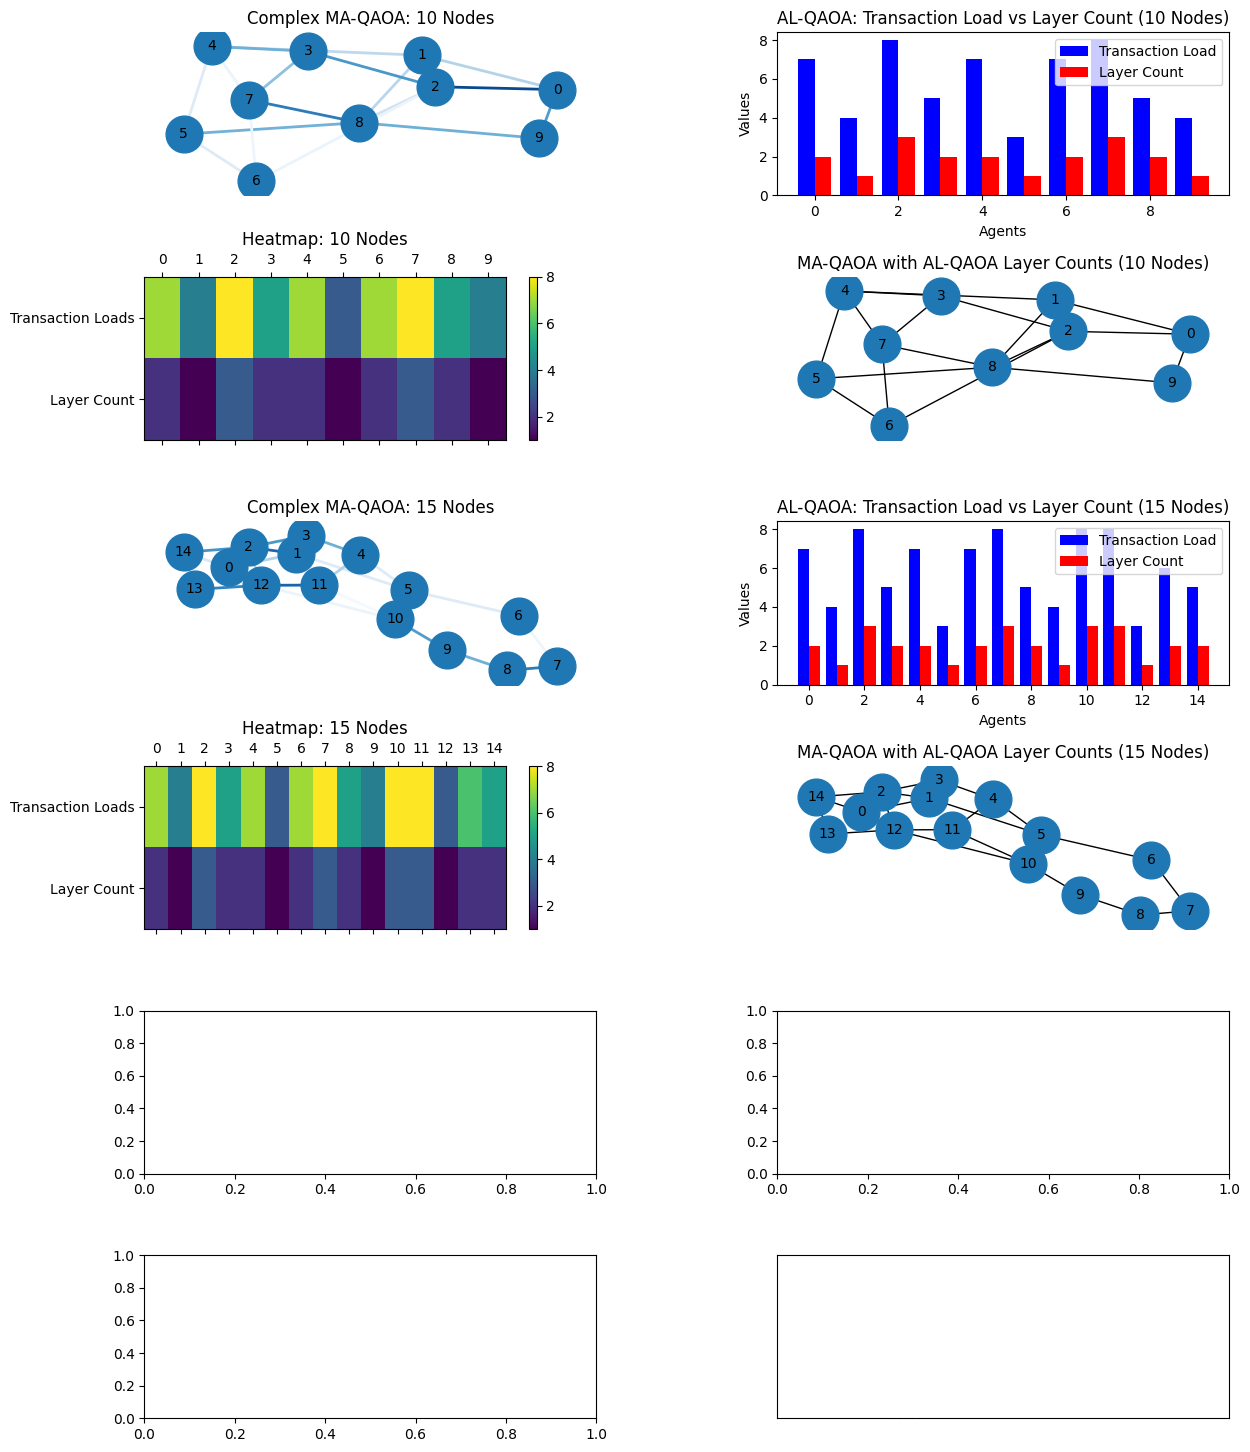

In [38]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 1. Complex MA-QAOA: Inter-Agent Connectivity
def ma_qaoa_complex_graph(num_nodes=10, extra_edges=5, seed=42):
    """
    Creates a complex MA-QAOA graph with circular, inner, and random connections.
    """
    np.random.seed(seed)
    G = nx.Graph()

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add circular edges
    circular_edges = [(i, (i + 1) % num_nodes, {'weight': np.random.uniform(0.1, 1.0)}) for i in range(num_nodes)]
    G.add_edges_from(circular_edges)

    # Add inner edges (non-adjacent nodes)
    inner_edges = []
    while len(inner_edges) < extra_edges:
        u, v = np.random.choice(num_nodes, 2, replace=False)
        if not G.has_edge(u, v) and abs(u - v) > 1:  # Avoid adjacent nodes
            inner_edges.append((u, v, {'weight': np.random.uniform(0.1, 0.8)}))
    G.add_edges_from(inner_edges)

    # Add random edges with a lower probability
    for _ in range(num_nodes):
        if np.random.rand() < 0.3:  # Random chance for additional connections
            u, v = np.random.choice(num_nodes, 2, replace=False)
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=np.random.uniform(0.2, 1.2))

    return G

# 2. AL-QAOA: Transaction Load vs Layer Count
def al_qaoa_data(num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    return transaction_loads, layers

# Plotting all graphs in a 2-column layout
def plot_all_graphs():
    fig, axes = plt.subplots(6, 2, figsize=(14, 18))
    plt.subplots_adjust(hspace=0.5, wspace=0.4)

    node_configs = [10, 15]
    graph_idx = 0

    for num_nodes in node_configs:
        # Generate MA-QAOA graph
        G = ma_qaoa_complex_graph(num_nodes=num_nodes)
        pos = nx.spring_layout(G, seed=42)

        # Plot MA-QAOA Graph
        ax = axes[graph_idx, 0]
        nx.draw(
            G, pos, ax=ax, with_labels=True, node_size=700, font_size=10,
            edge_color=[d['weight'] for (_, _, d) in G.edges(data=True)],
            edge_cmap=plt.cm.Blues, edge_vmin=0.1, edge_vmax=1.2, width=2
        )
        ax.set_title(f"Complex MA-QAOA: {num_nodes} Nodes")

        # Generate AL-QAOA Data
        transaction_loads, layers = al_qaoa_data(num_agents=num_nodes)

        # Plot AL-QAOA Bar Chart
        ax = axes[graph_idx, 1]
        x = np.arange(num_nodes)
        ax.bar(x - 0.2, transaction_loads, width=0.4, label="Transaction Load", color='blue')
        ax.bar(x + 0.2, layers, width=0.4, label="Layer Count", color='red')
        ax.set_xlabel("Agents")
        ax.set_ylabel("Values")
        ax.set_title(f"AL-QAOA: Transaction Load vs Layer Count ({num_nodes} Nodes)")
        ax.legend()

        graph_idx += 1

        # Combined Representation
        heatmap_data = np.array([transaction_loads, layers])

        # Plot Heatmap
        ax = axes[graph_idx, 0]
        cax = ax.matshow(heatmap_data, cmap='viridis', aspect='auto')
        fig.colorbar(cax, ax=ax)
        ax.set_xticks(range(num_nodes))
        ax.set_yticks([0, 1])
        ax.set_yticklabels(["Transaction Loads", "Layer Count"])
        ax.set_title(f"Heatmap: {num_nodes} Nodes")

        # Overlay on MA-QAOA Graph
        ax = axes[graph_idx, 1]
        node_labels = {i: f"L: {layers[i]}" for i in G.nodes()}
        nx.draw(G, pos, ax=ax, with_labels=True, node_size=700, font_size=10)
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="white")
        ax.set_title(f"MA-QAOA with AL-QAOA Layer Counts ({num_nodes} Nodes)")

        graph_idx += 1

    plt.show()

# Call the function to plot all graphs
plot_all_graphs()

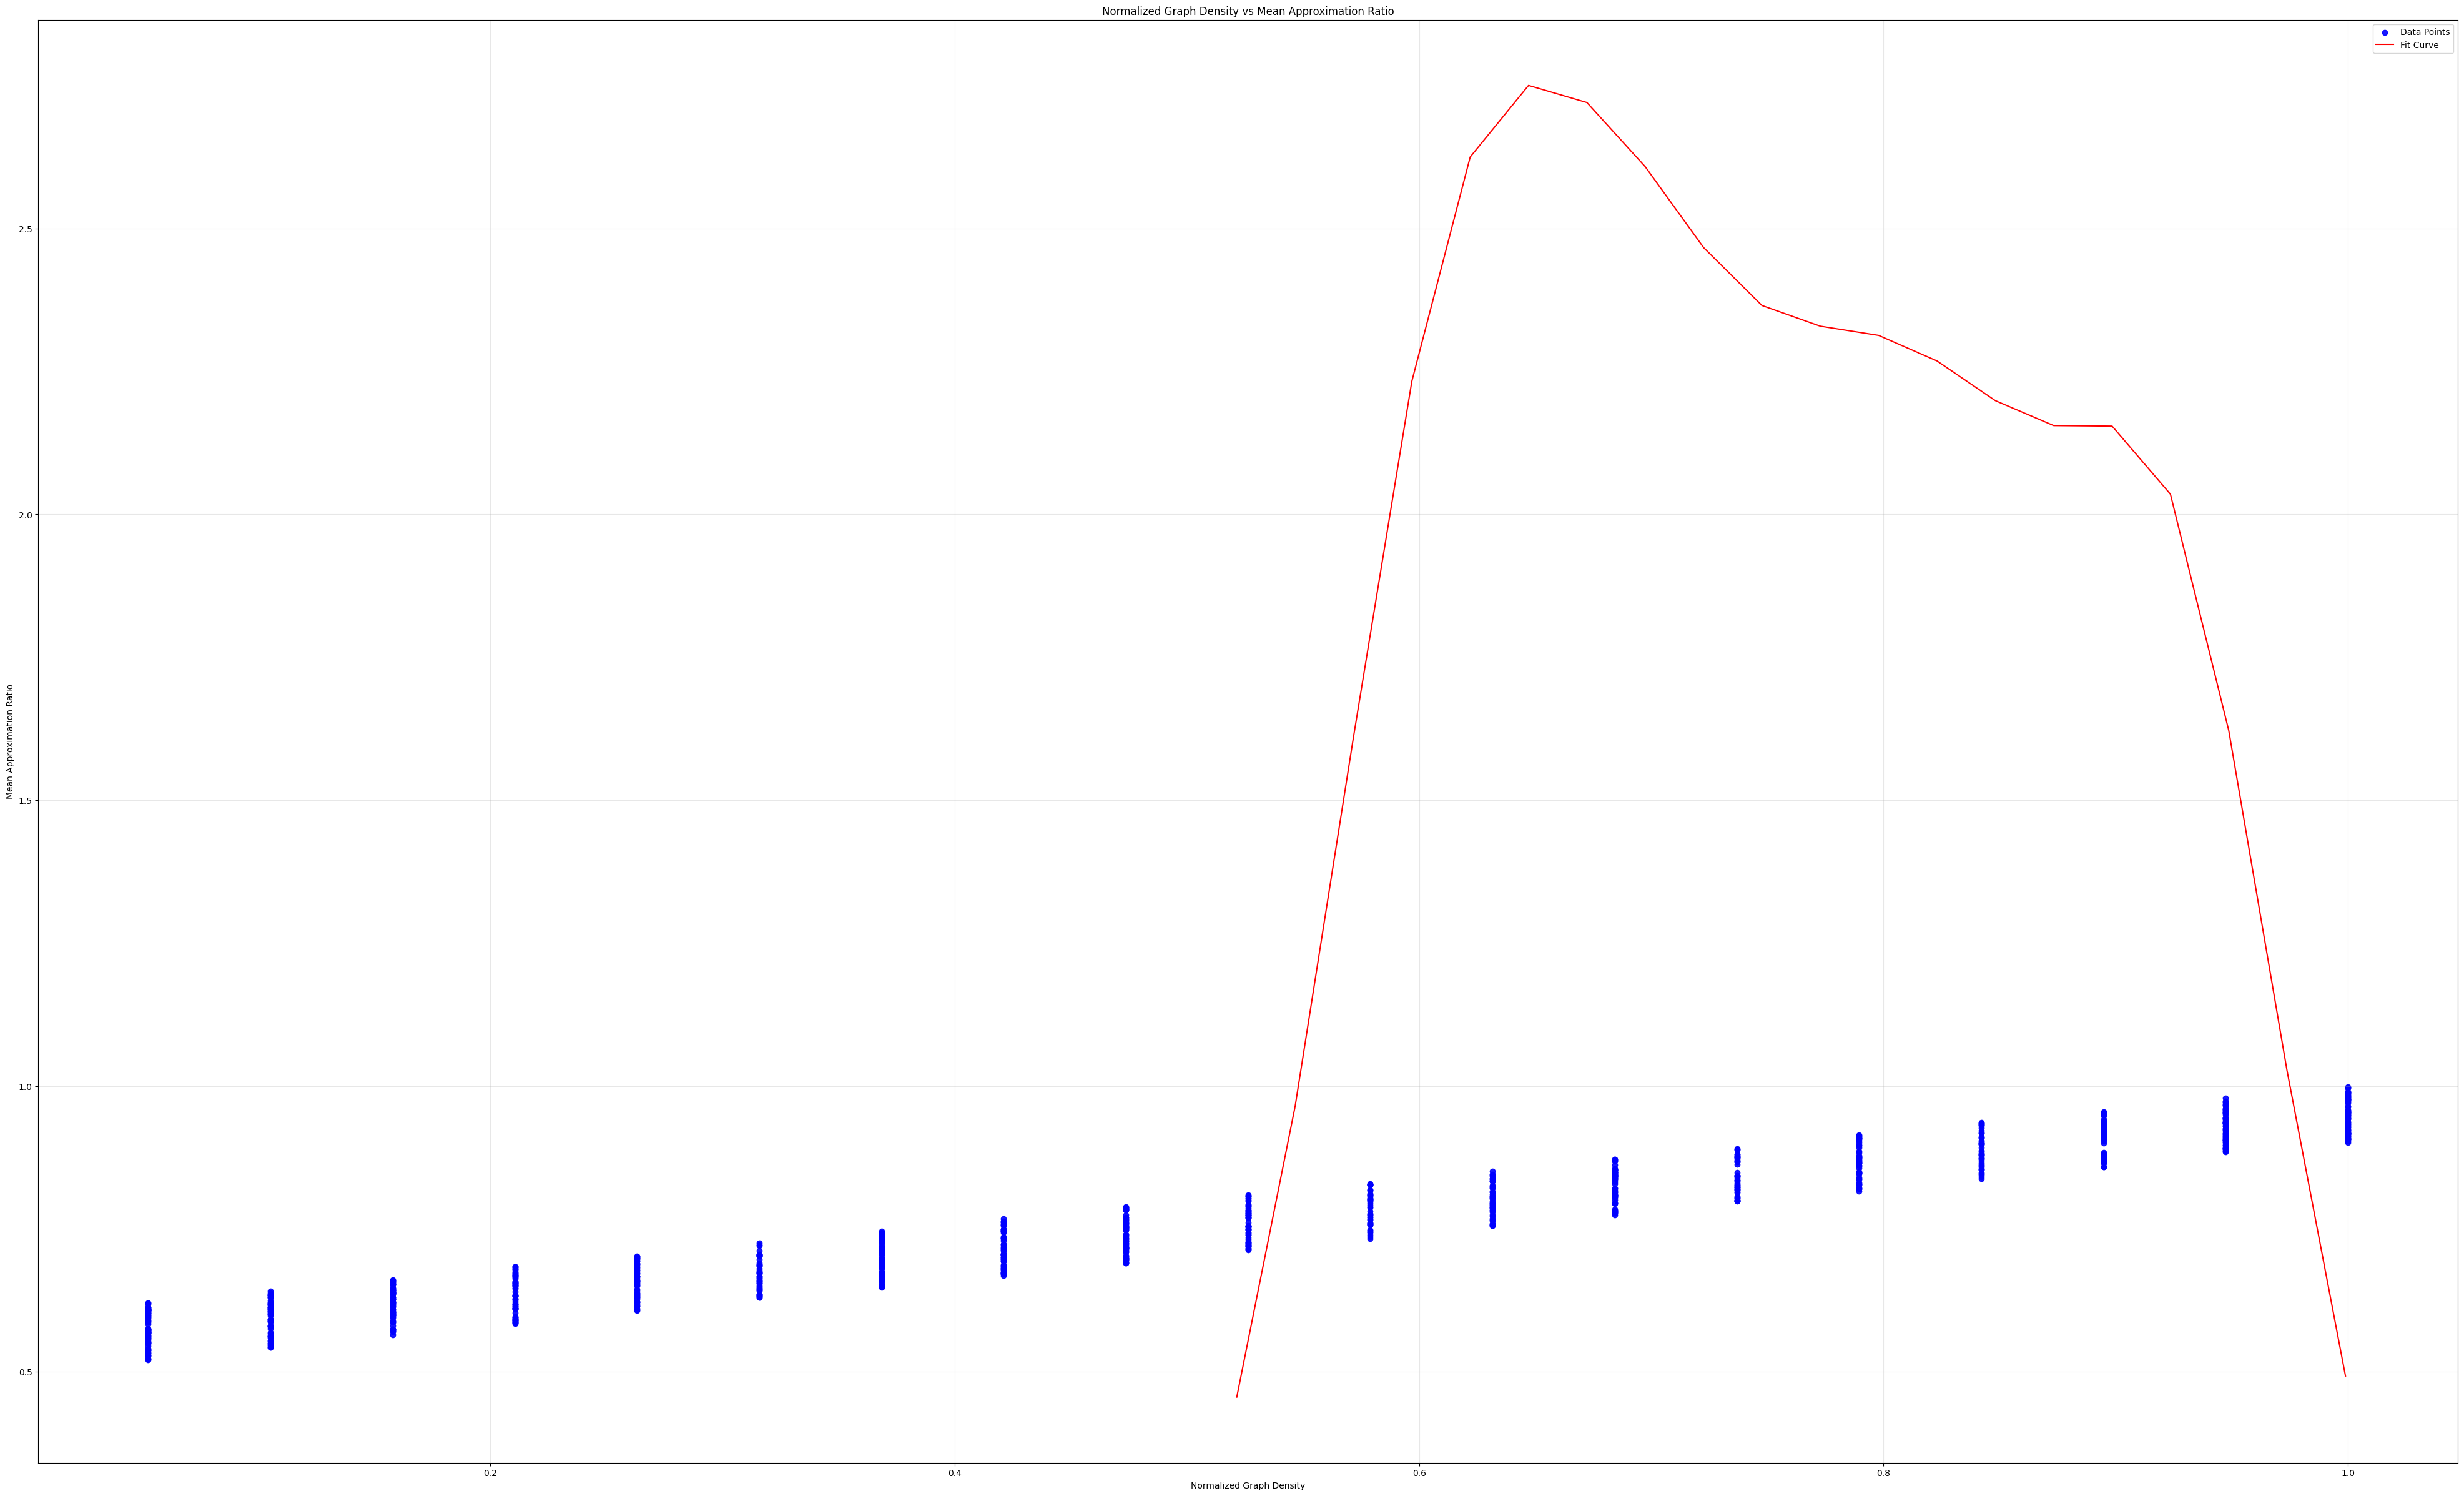

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Number of agents and their transaction loads
agents = 24
transaction_loads = np.random.randint(1, 20, size=agents)  # Random transaction loads for each agent
threshold = 10  # Threshold for layer adjustment
alpha = 1.0  # Scaling factor for layers
p_max = 5  # Maximum layers

# Calculate layer counts
layer_count = np.minimum(p_max, np.ceil(alpha * transaction_loads / threshold).astype(int))

# Normalize transaction loads to represent graph density
normalized_density = transaction_loads / transaction_loads.max()

# Simulate mean approximation ratio
mean_approx_ratio = 0.5 + 0.4 * normalized_density + 0.1 * np.random.rand(agents)

# Scatter plot for normalized density vs mean approximation ratio
plt.figure(figsize=(50, 30))
plt.scatter(normalized_density, mean_approx_ratio, alpha=0.9, color='blue', label="Data Points")

# Fit a density curve
density = gaussian_kde(mean_approx_ratio)
x_vals = np.linspace(mean_approx_ratio.min(), mean_approx_ratio.max(), 20)
density_vals = density(x_vals)

# Overlay density curve
plt.plot(x_vals, density_vals, color='red', label="Fit Curve")

# Add labels, legend, and title
plt.xlabel("Normalized Graph Density")
plt.ylabel("Mean Approximation Ratio")
plt.title("Normalized Graph Density vs Mean Approximation Ratio")
plt.legend()
plt.grid(alpha=0.3)

# Show plot
plt.show()
